### Libraries

In [1]:
library('stringr')
library(tidyr)
library(dplyr)
library(ggplot2)
library('DescTools')
options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Configuration for confidence intervals

Every confidence interval for particalar week will be created with specific number of years before 2019 and weeks forth and back.

In [2]:
years_back = 5
weeks_window = 2

### Data preparation.

In [6]:
data <- read.csv(paste(Sys.getenv('WORKDIR'),'/Data/demo_r_mwk_ts_1_Data.csv',sep=''))
data[,'Value'] <- as.numeric(gsub(",", "", data[,'Value']))

In [7]:
data$Year <- as.integer(substr(data$TIME,0,4))
data$Week <- as.integer(substr(data$TIME,6,7))
data <- data[,c('Year','Week','GEO','Value')]
data$GEO[data$GEO=='Germany (until 1990 former territory of the FRG)']<-'Germany'
data <- data %>% filter(!is.na(Value) & Week < 53) %>% arrange(GEO)

countries <- data %>% 
    filter(Year < 2019 & !is.na(Value) & Week < 53) %>%
    count(GEO,Week) %>%
    group_by(GEO) %>%
    filter(all(n>years_back)) %>% 
    distinct(GEO)

data <- data %>%
    filter(GEO %in% countries$GEO) %>%
    filter(Year < 2022)

### Functions for lower and upper bound of confidence intervals assuming t distribution for sample or poisson distribution for mean of sample.

In [8]:
l_bound_t <- function(x,alpha){
    x = na.omit(x)
    n = length(x)
    alpha = (1+alpha)/2
    mean(x) - qt(alpha, n-1)*sd(x)/sqrt(n)
}
u_bound_t <- function(x,alpha){
    x = na.omit(x)
    n = length(x)
    alpha = (1-alpha)/2
    mean(x) - qt(alpha, n-1)*sd(x)/sqrt(n)
}
l_bound_poisson <- function(x,alpha){
    PoissonCI(round(mean(x,na.rm = TRUE),0), n = 1, conf.level = alpha, sides = "two.sided", method = "exact")[2]
}
u_bound_poisson <- function(x,alpha){
    PoissonCI(round(mean(x,na.rm = TRUE),0), n = 1, conf.level = alpha, sides = "two.sided", method = "exact")[3]
}

### Function creating polygon for confidence intervals.

In [9]:
polygon <- function(f_l_bound,f_u_bound, name,...){
    MIN_MAX <- data.frame('GEO'=character(),'MIN'=double(),'MAX'=double())
    year = (2018-years_back+1):2018
    k=-weeks_window:weeks_window
    for(week in 1:52){
        a=rep(year,each=length(k)) + rep(floor((week-1+k)/52),times=length(year))
        b=rep((week-1+k)%%52+1,times=length(year))
        y_w = data.frame('Year' = a,'Week' = b)
        MIN_MAX <- data %>%
        inner_join(y_w, by = c('Year','Week')) %>%
        group_by(GEO) %>% 
        summarise(MIN = f_l_bound(Value, ...), MAX = f_u_bound(Value, ...), Week = week) %>%
        union_all(MIN_MAX)
    }

    polygon_up <- MIN_MAX %>%
      group_by(GEO) %>%
      select(-MIN) %>%
      arrange(desc(Week)) %>%
      rename(Value = MAX) %>%
      mutate(Year = name)

    polygon_down <- MIN_MAX %>%
      group_by(GEO) %>%
      select(-MAX) %>%
      arrange(Week) %>%
      rename(Value = MIN) %>%
      mutate(Year = name)

    rbind(polygon_down,polygon_up)
    }

In [10]:
polygon1 <- polygon(min,max,'min_max',na.rm = TRUE)
polygon2 <- polygon(l_bound_t,u_bound_t,'t',0.99)
polygon3 <- polygon(l_bound_poisson,u_bound_poisson,'poisson',0.99)

### Function creating desired plot for given countries.

In [11]:
plot <- function(charts = 1){
    Countries = unique(data$GEO)[charts]
    polygon_f1 <- polygon1 %>% filter(GEO %in% Countries)
    polygon_f2 <- polygon2 %>% filter(GEO %in% Countries)
    polygon_f3 <- polygon3 %>% filter(GEO %in% Countries)
    data %>%
        filter(Year %in% c(2019,2020,2021)) %>%
        filter(GEO %in% Countries) %>%
        ggplot(aes(Week,Value,fill=as.factor(Year),color=as.factor(Year))) +
        geom_polygon(data=polygon_f1) +
        geom_polygon(data=polygon_f3) +
        geom_polygon(data=polygon_f2) +
        geom_line(size = 1.1) +
        xlim(c(0,53))+
        facet_grid(rows = vars(GEO), scales = "free") +
        scale_fill_manual(
            name='Year', values = c('min_max'="bisque1",'poisson'="bisque3",'t'="bisque4",
                                    '2019'="deepskyblue", '2020'="deepskyblue4",'2021'="black")) +
        scale_color_manual(
            name='Year', values = c('min_max'="bisque1",'poisson'="bisque3",'t'="bisque4", 
                                    '2019'="deepskyblue", '2020'="deepskyblue4",'2021'="black")) +
        scale_y_continuous(name = 'Number of deaths in thousands', 
                         labels = scales::unit_format(
                           unit = "k", 
                           scale = 1e-3,
                           accuracy = 0.1)) +
        labs(title = paste(Countries,collapse=', '))
    
}

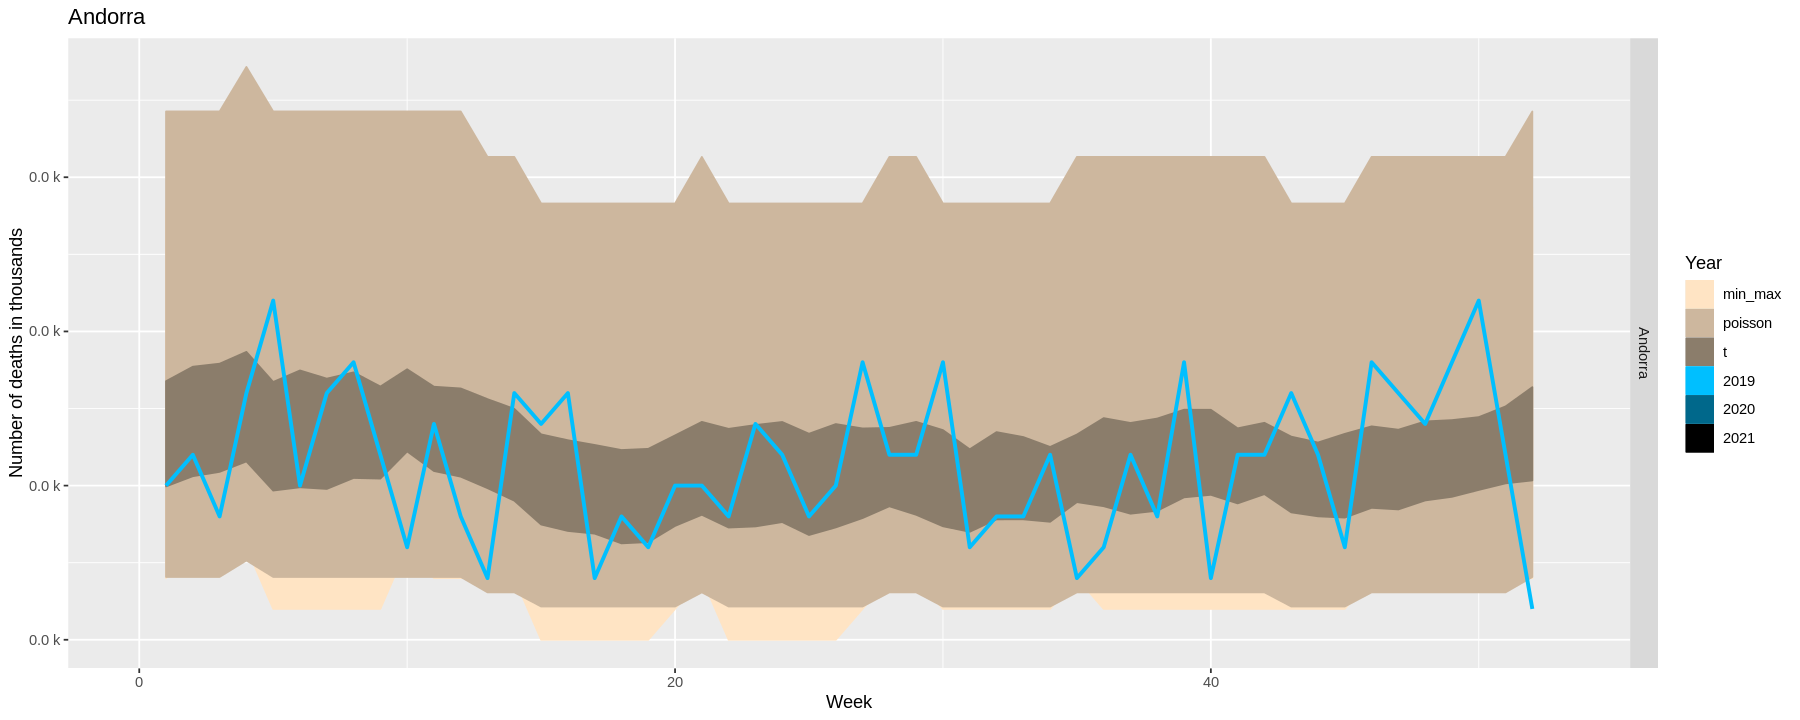

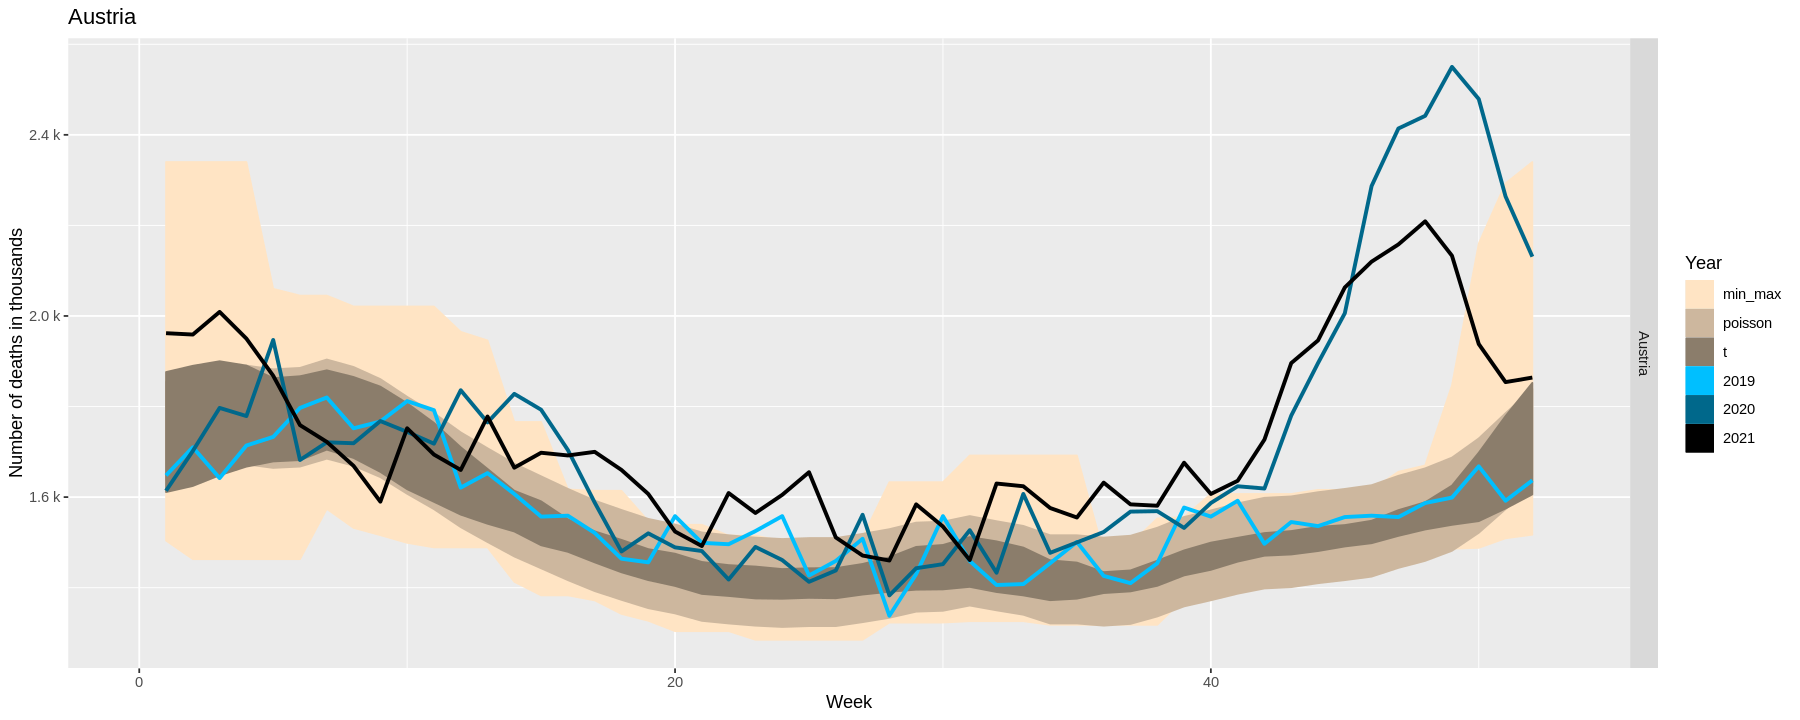

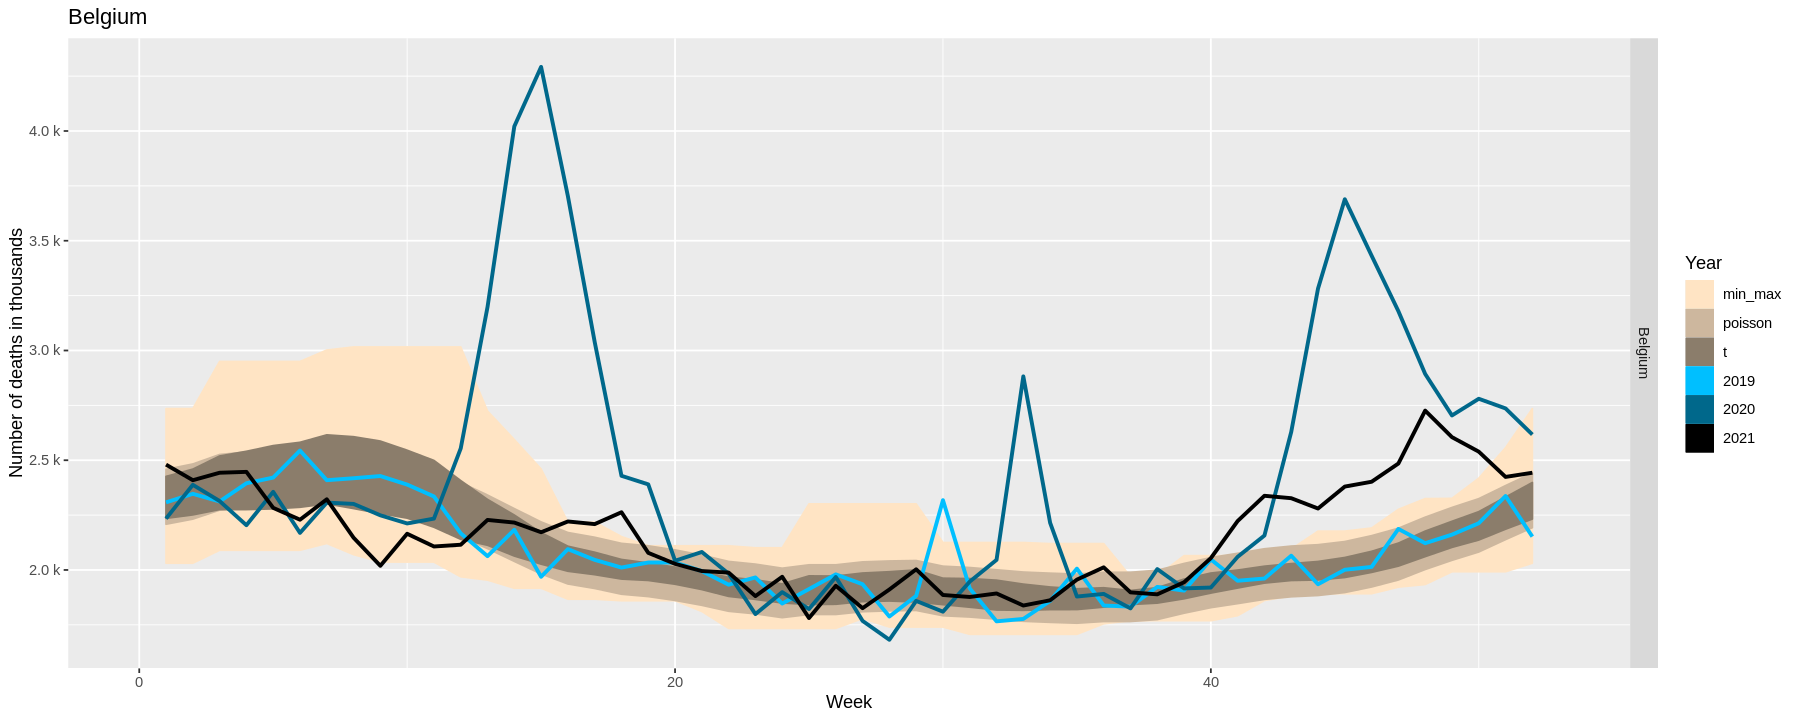

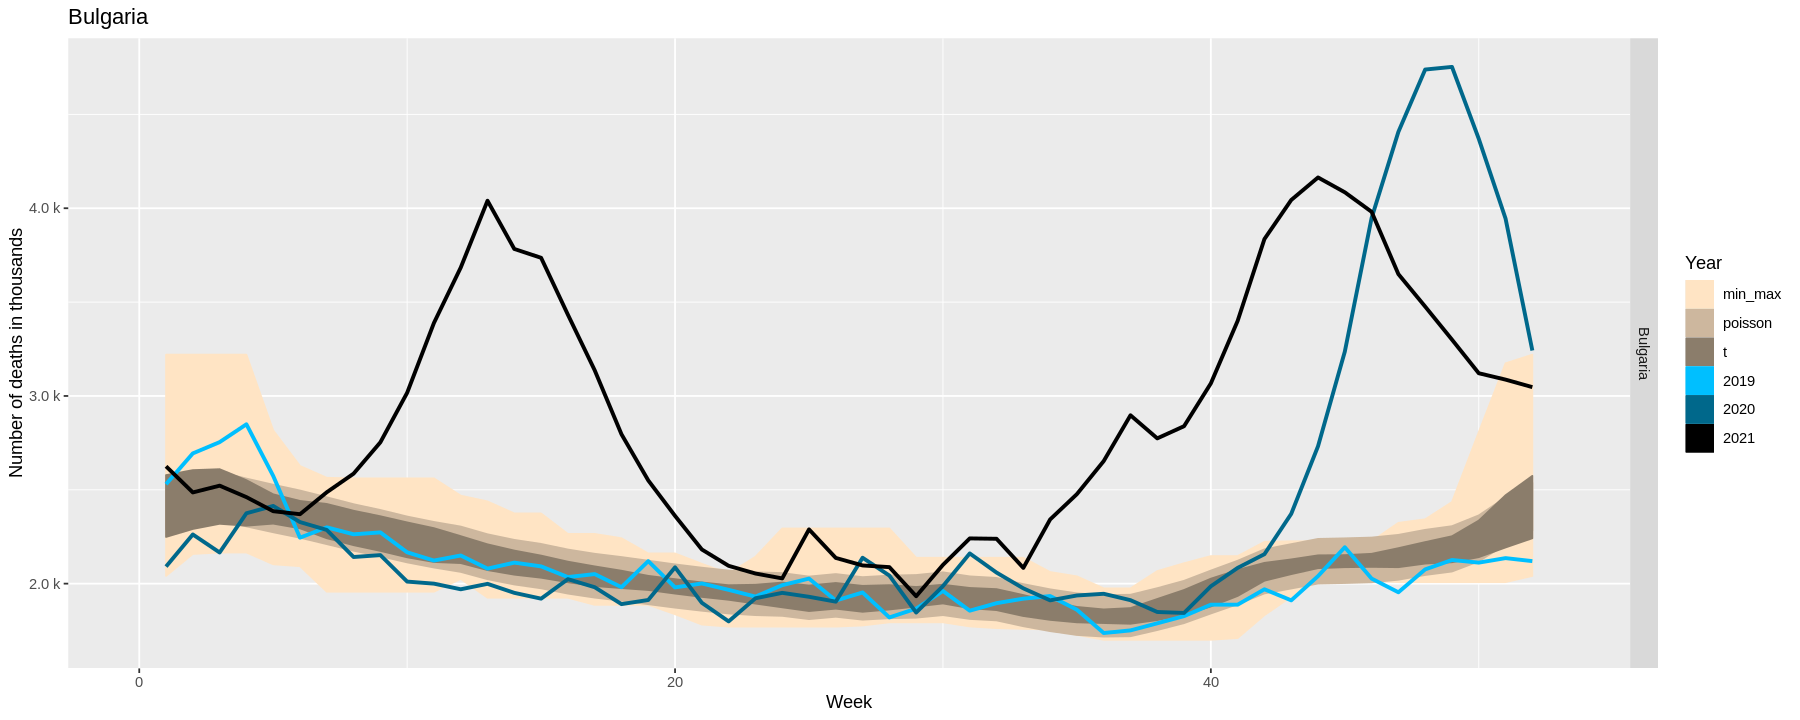

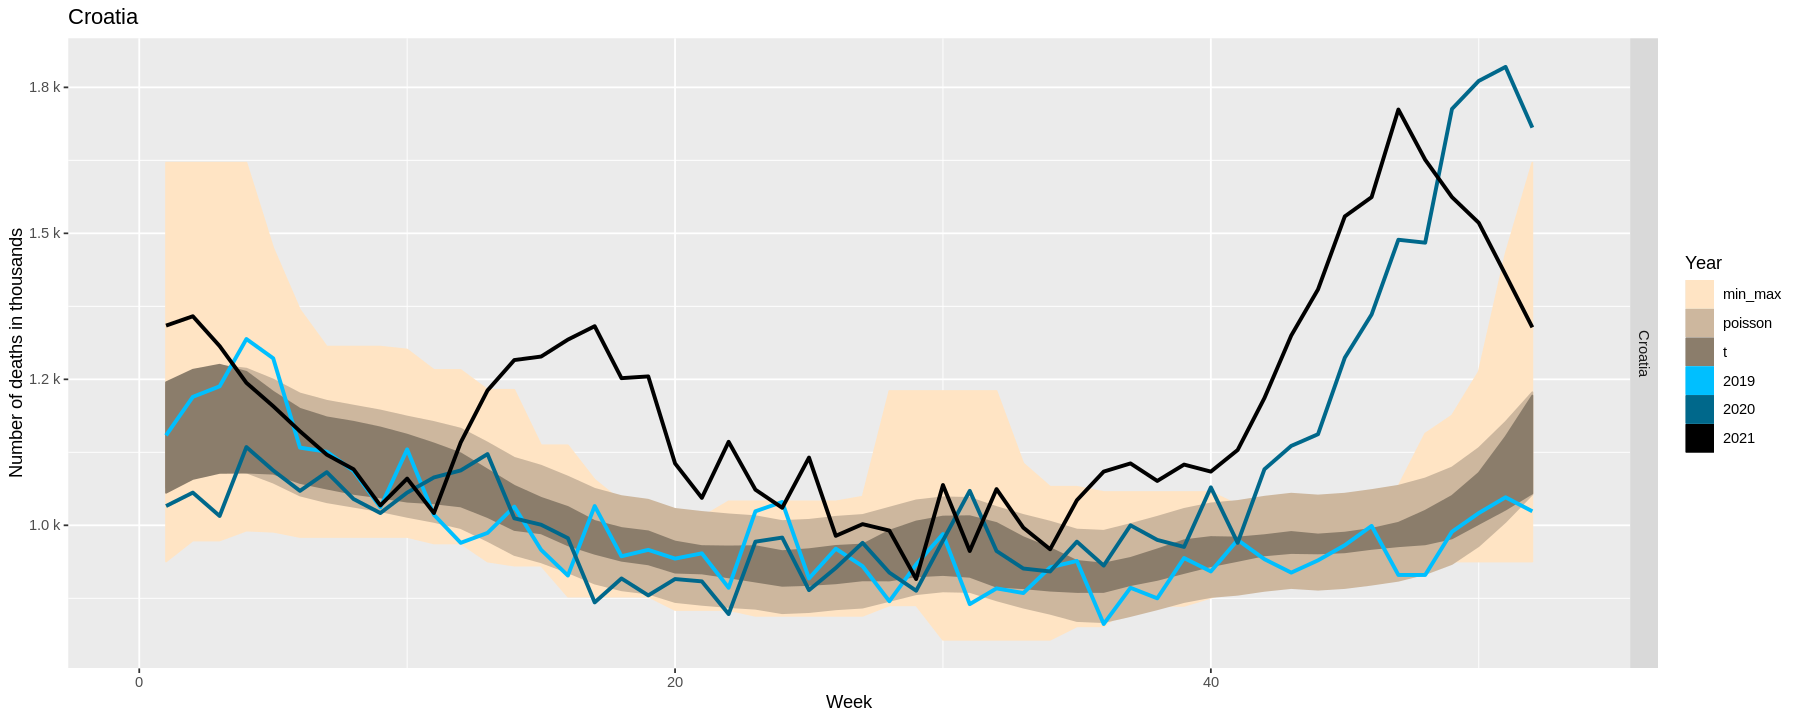

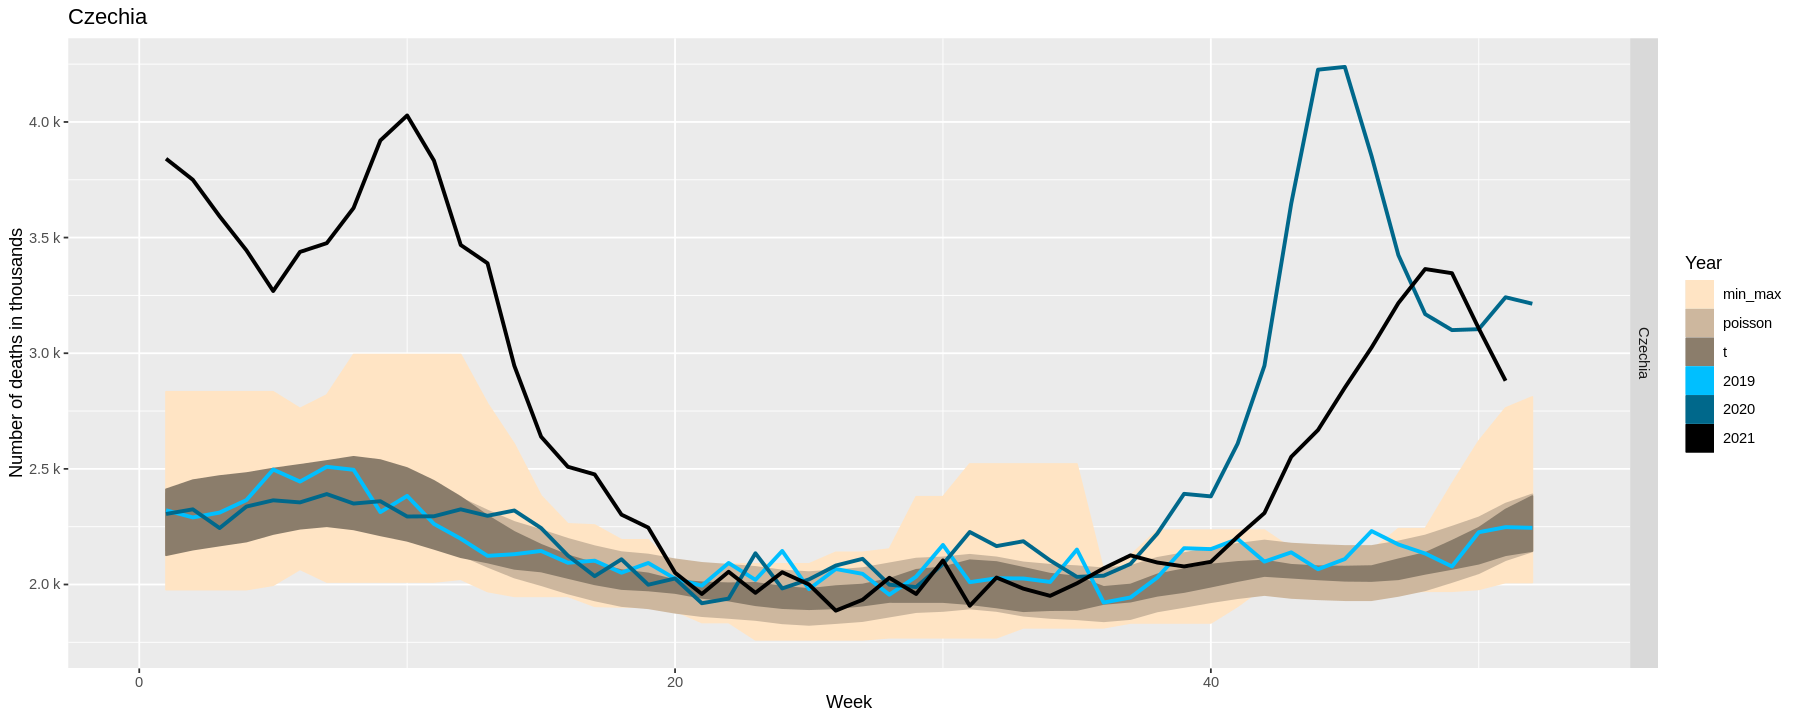

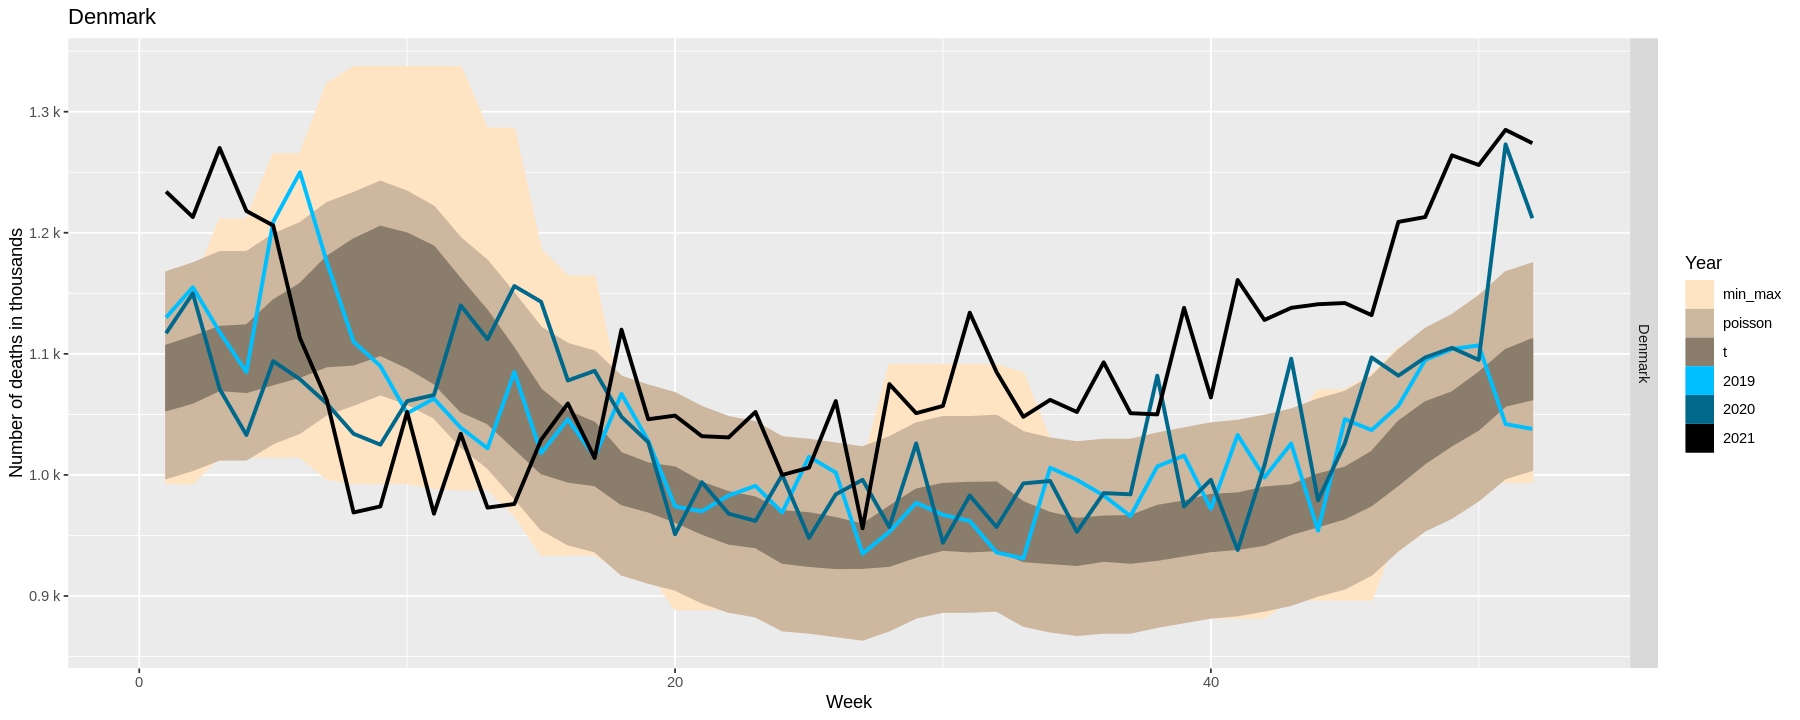

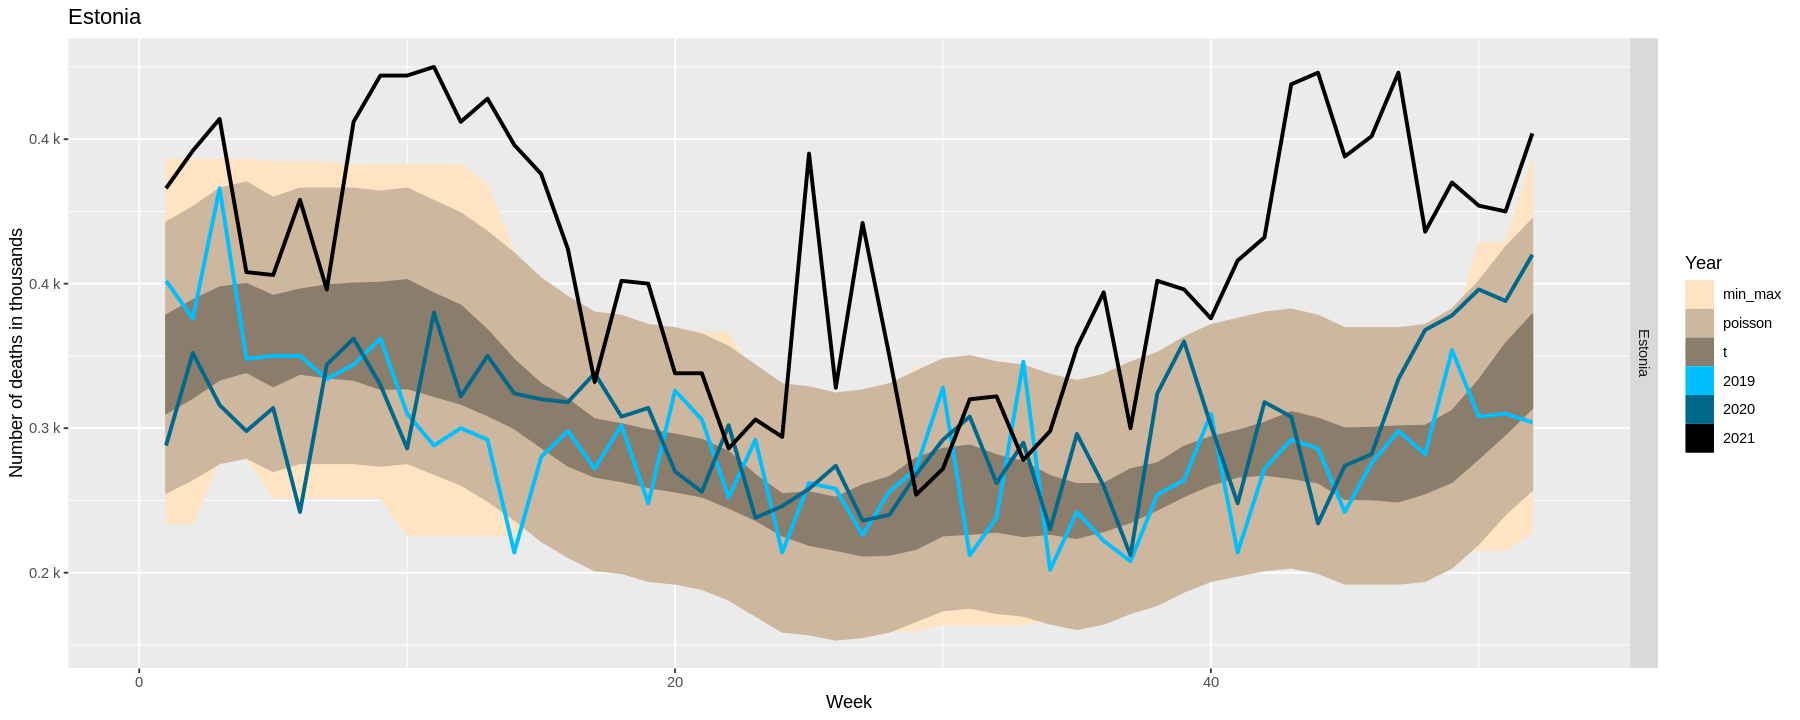

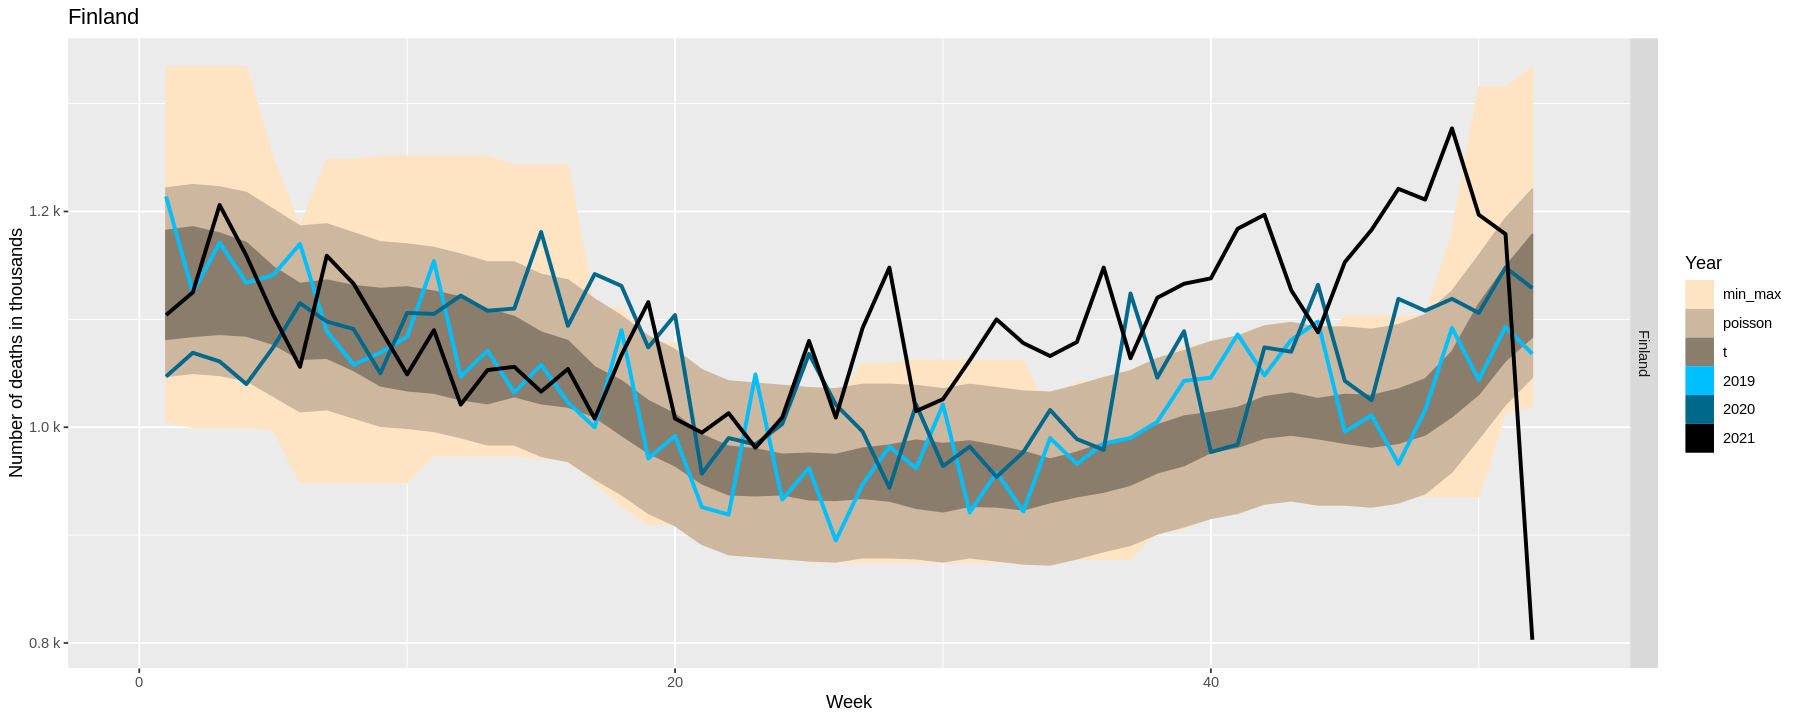

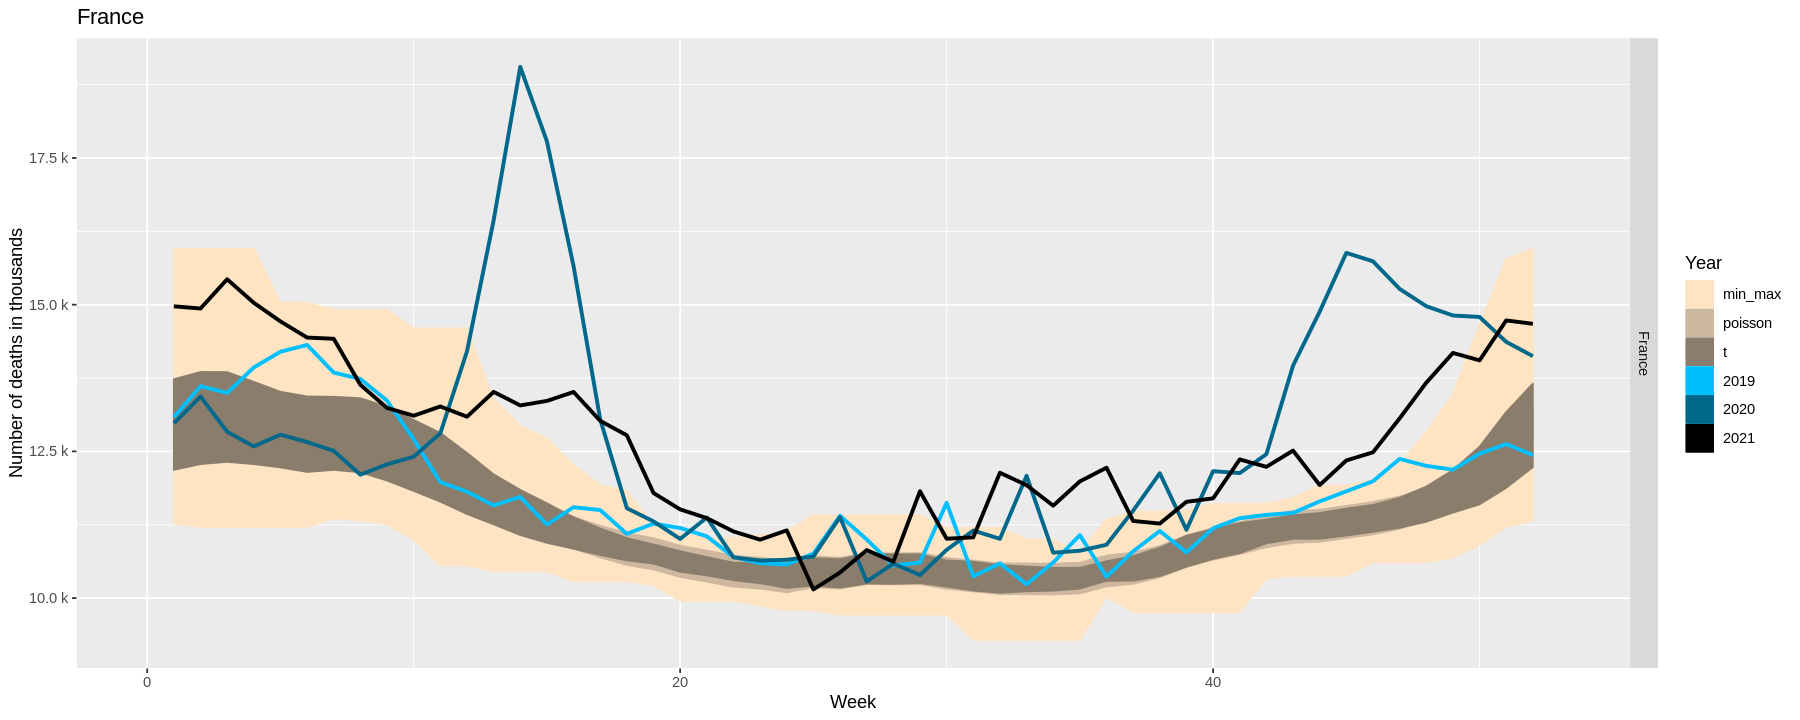

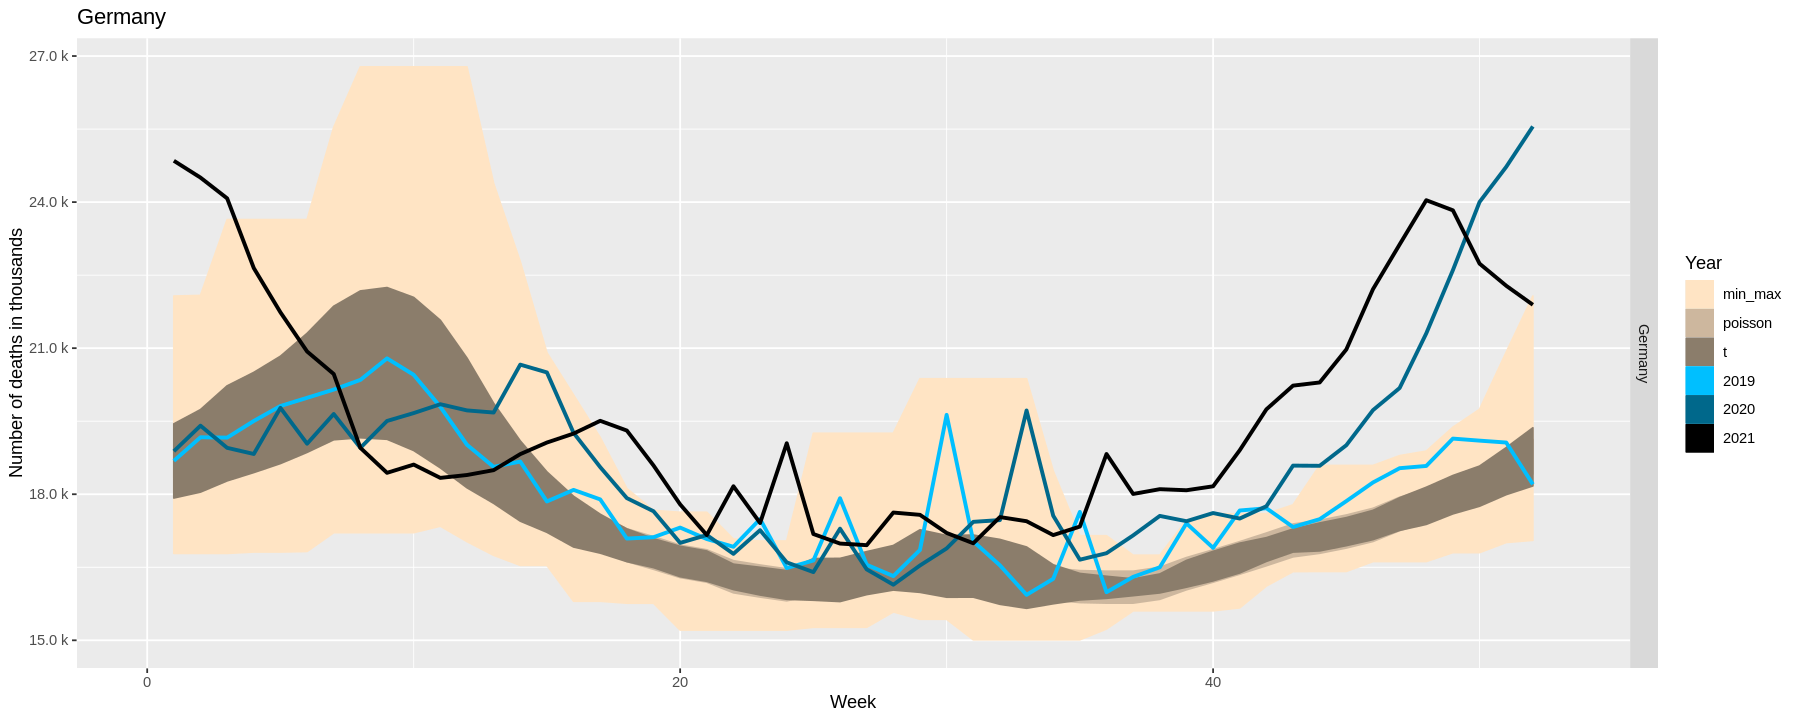

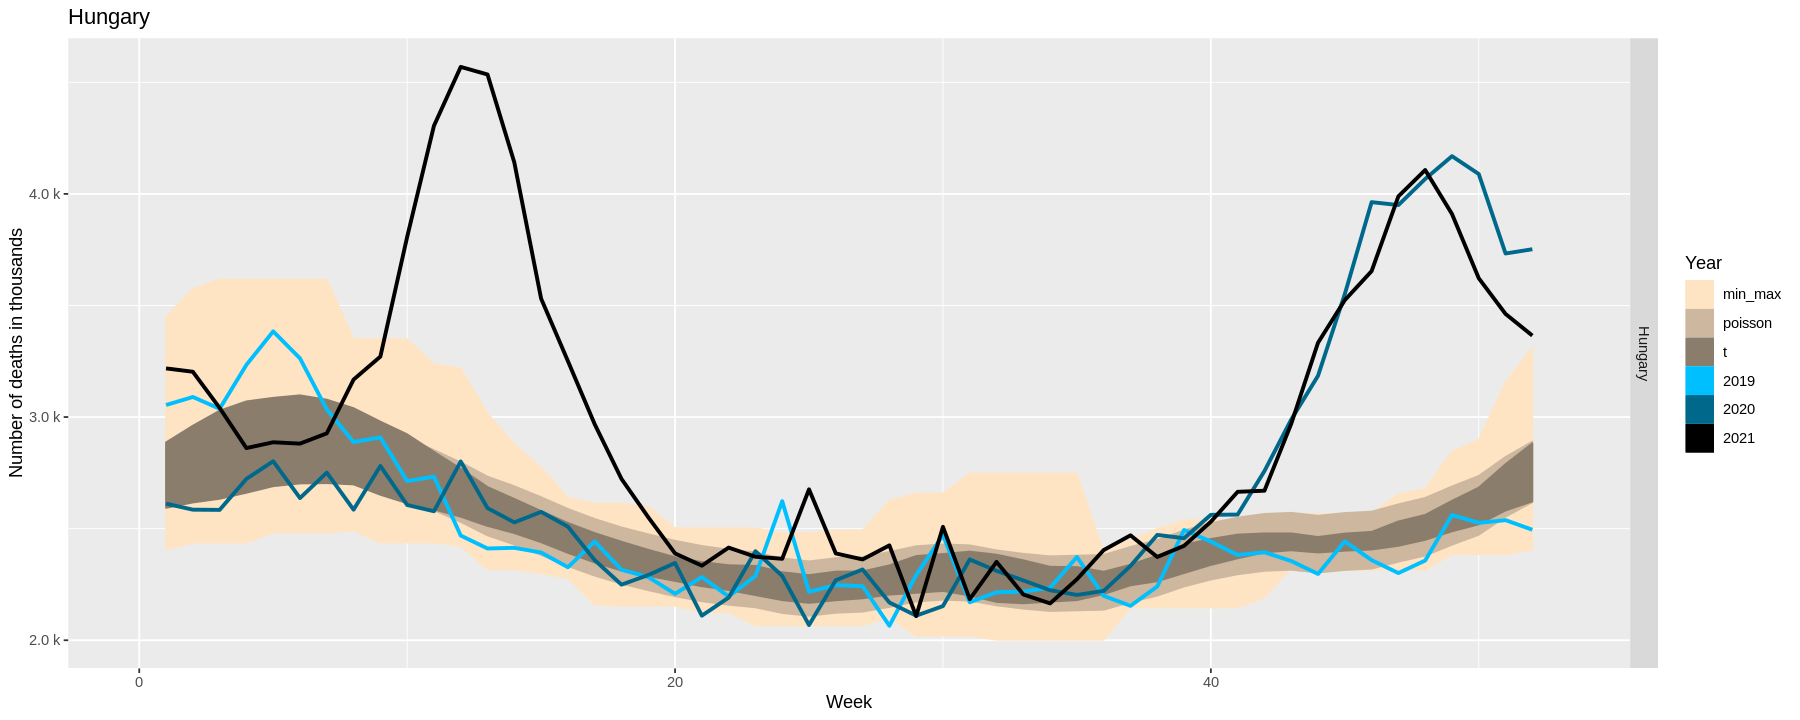

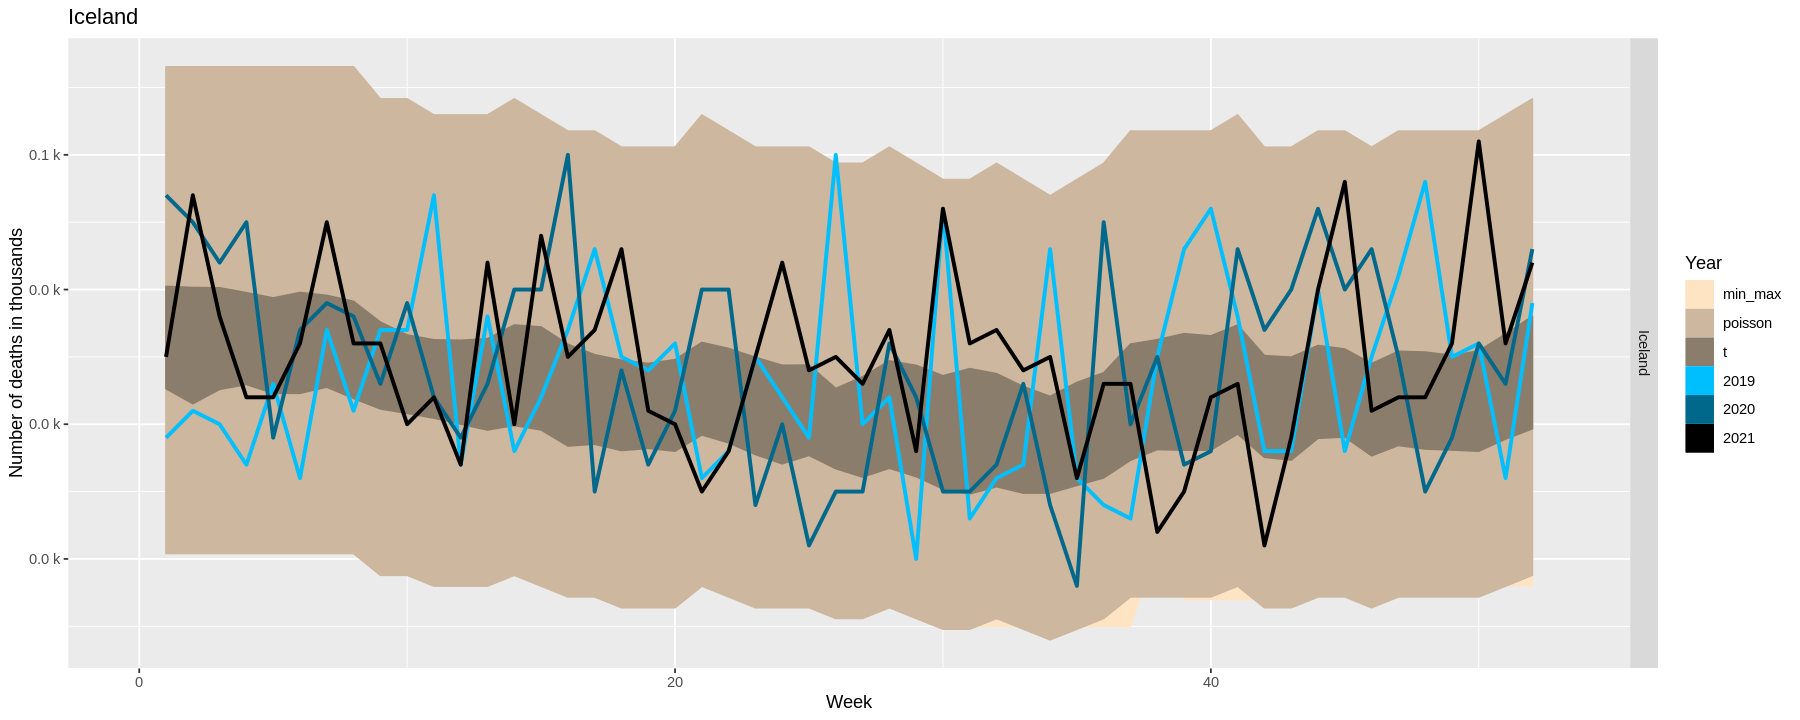

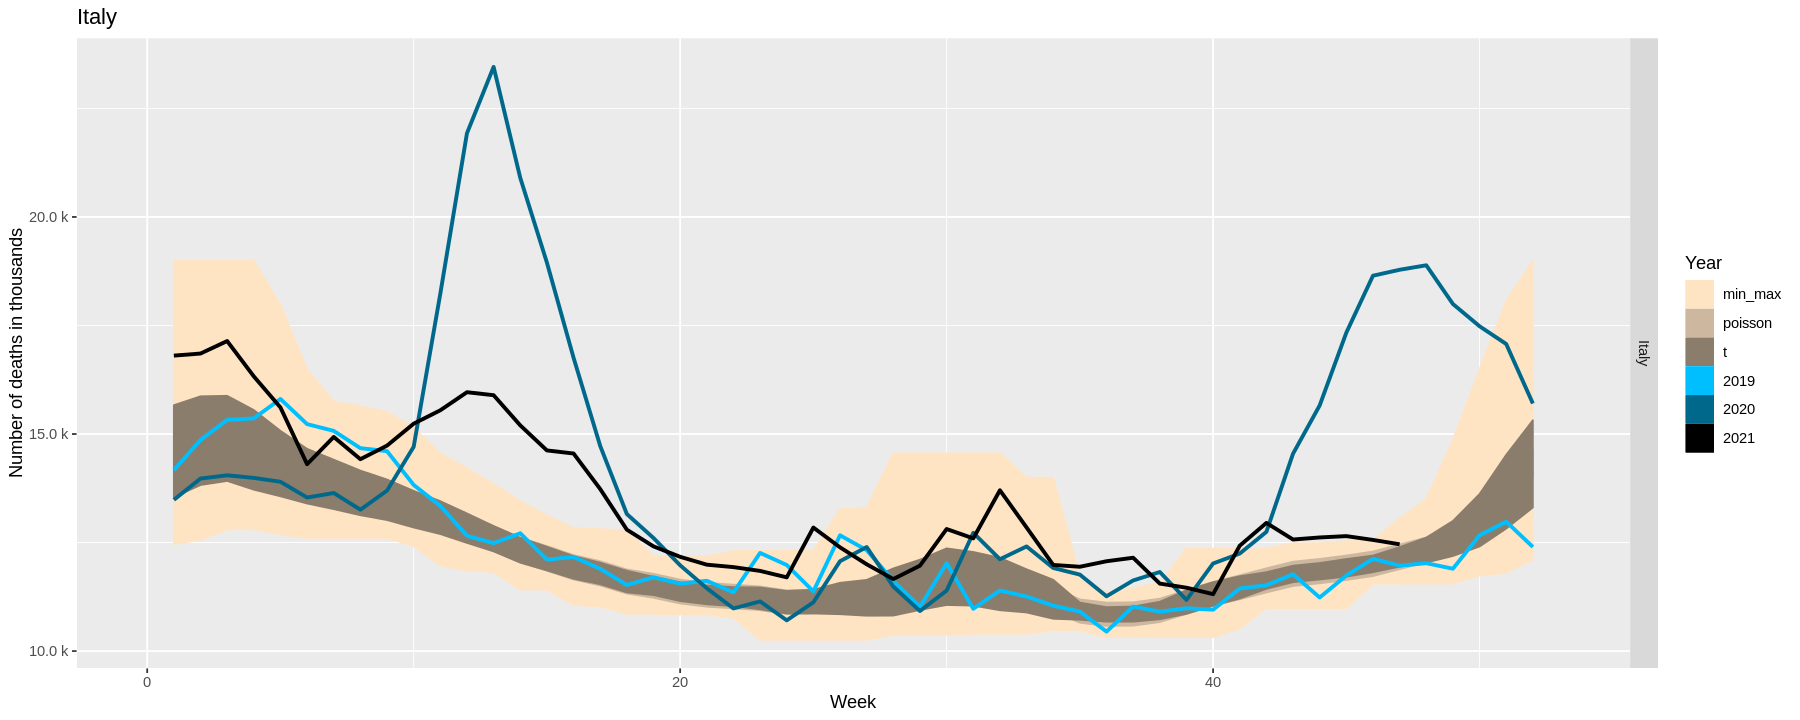

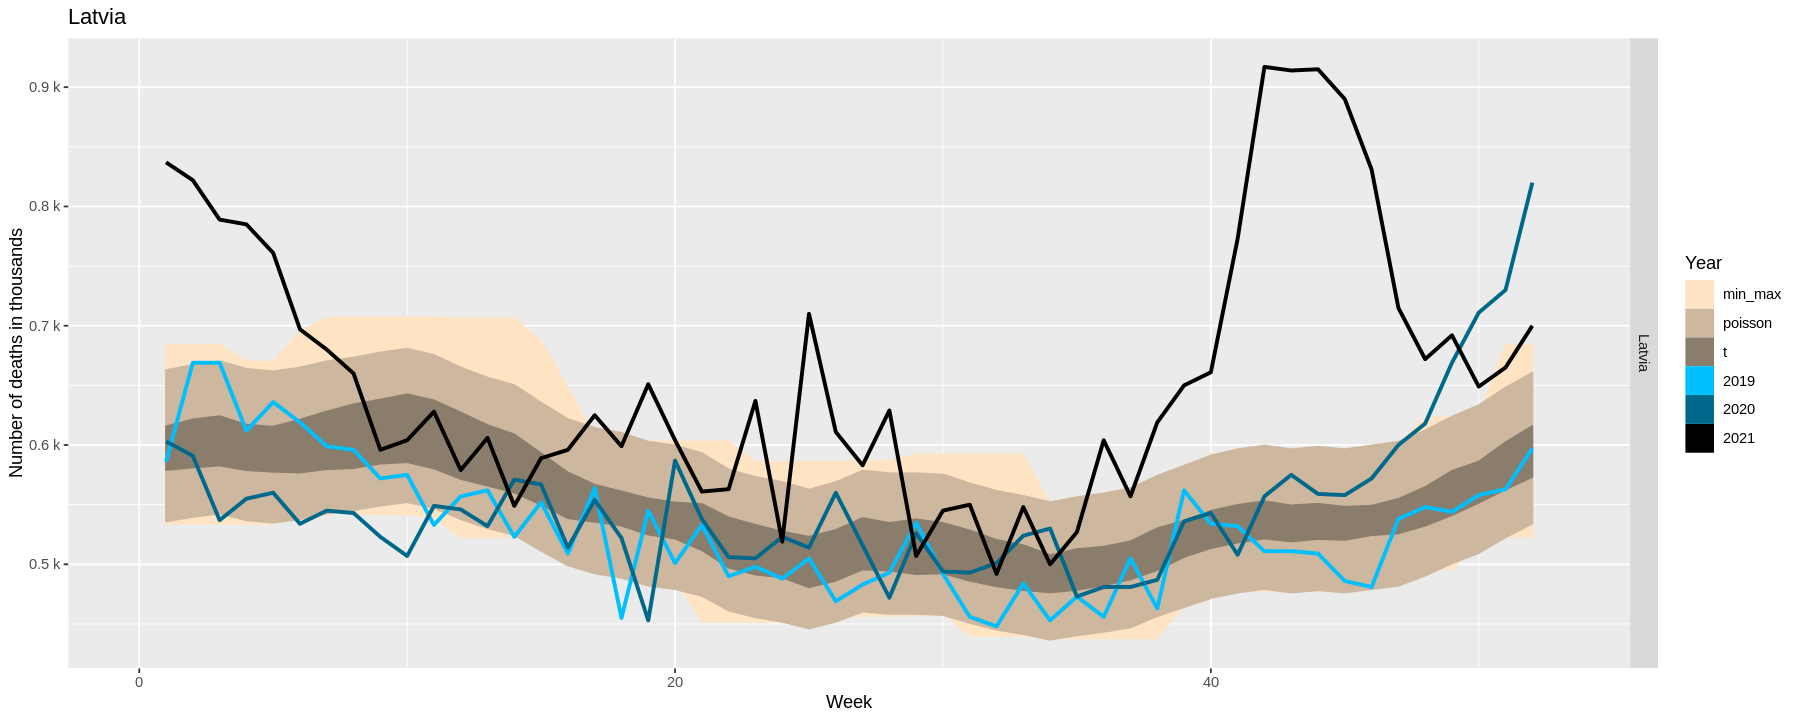

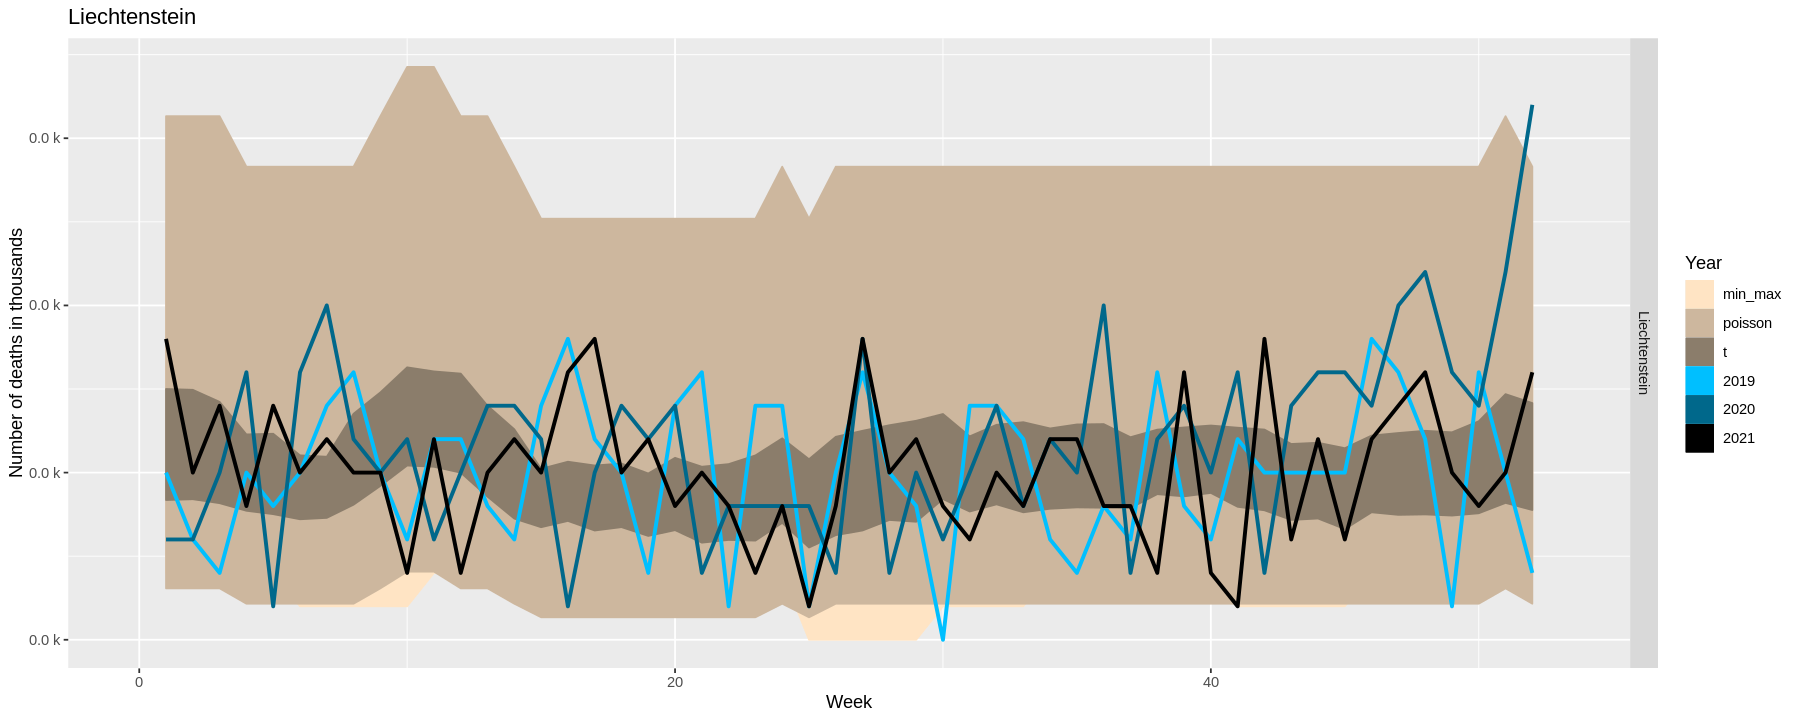

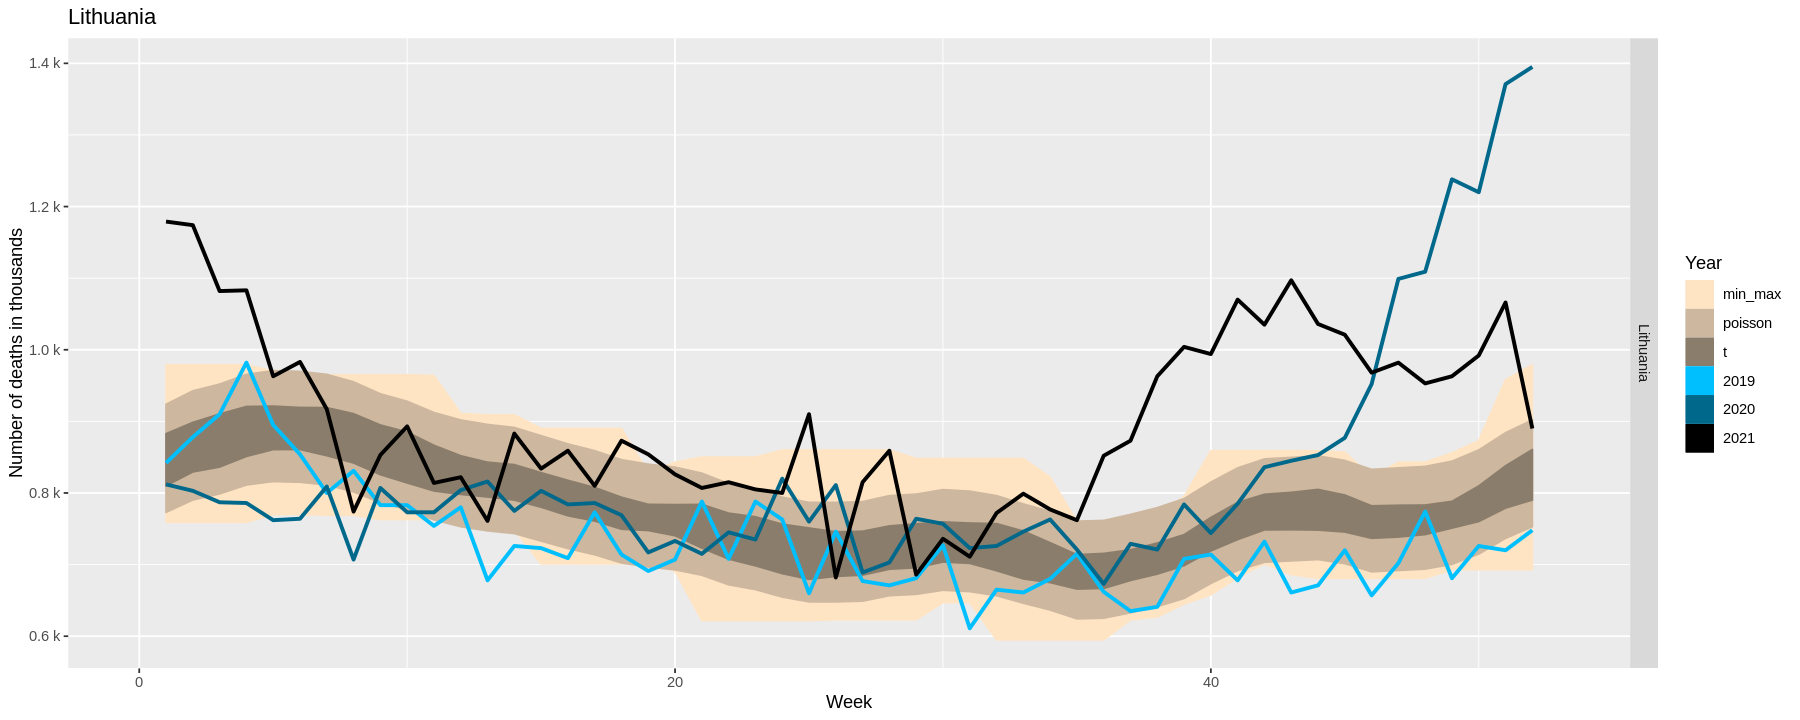

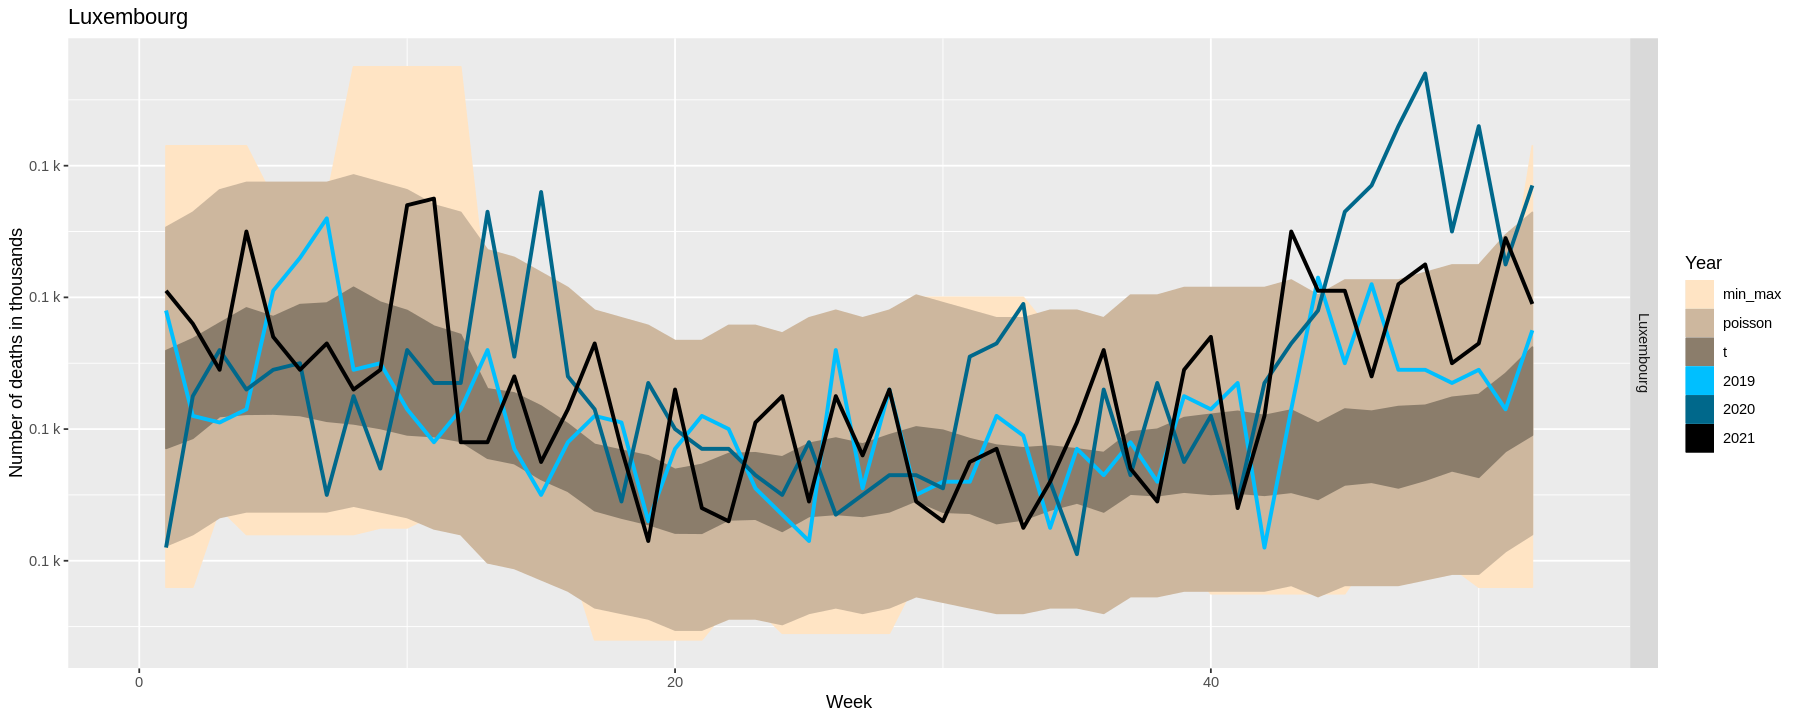

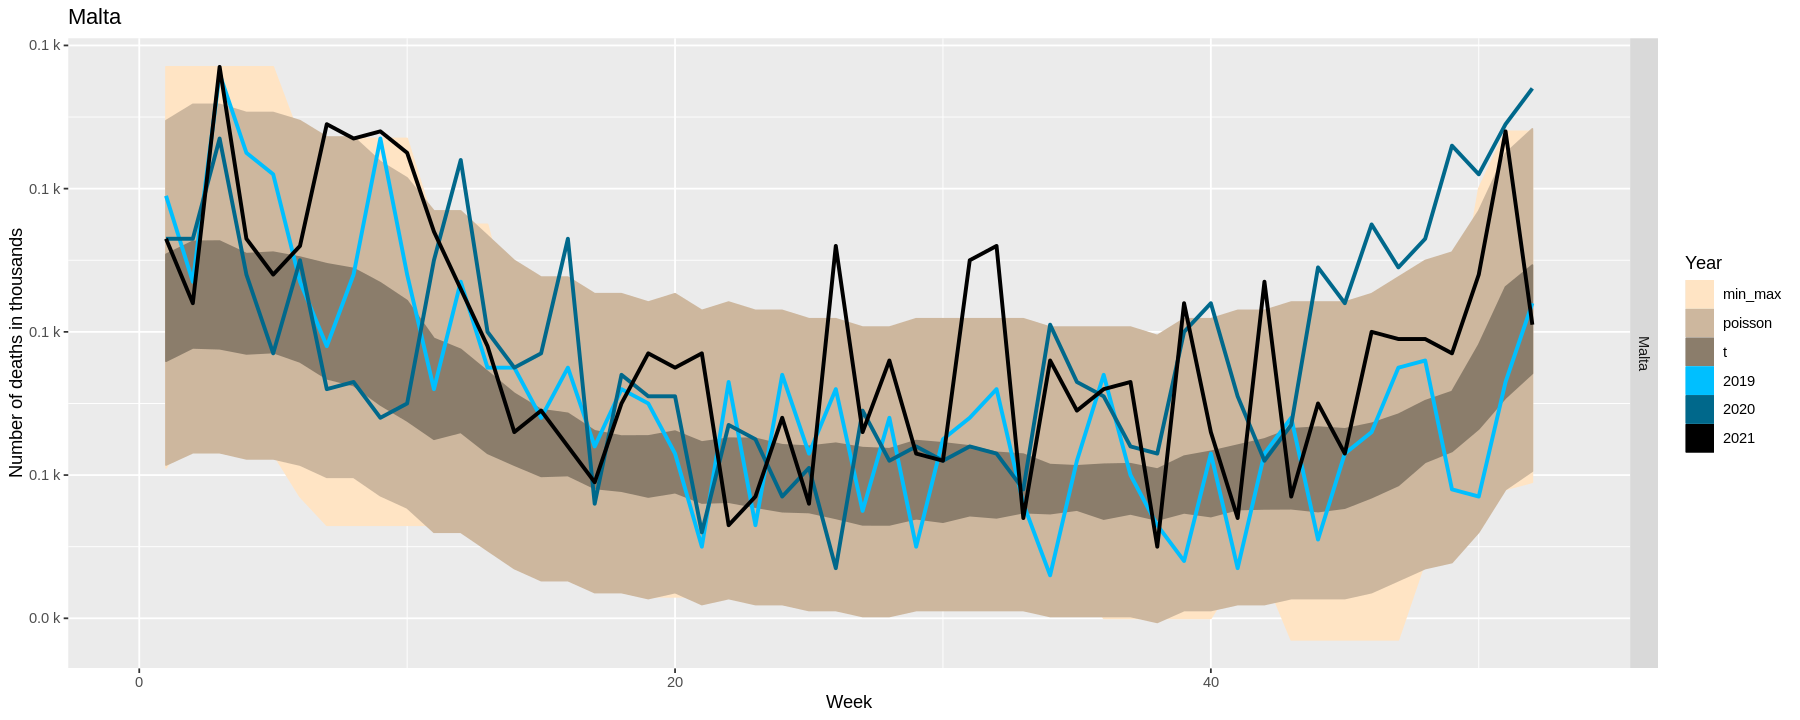

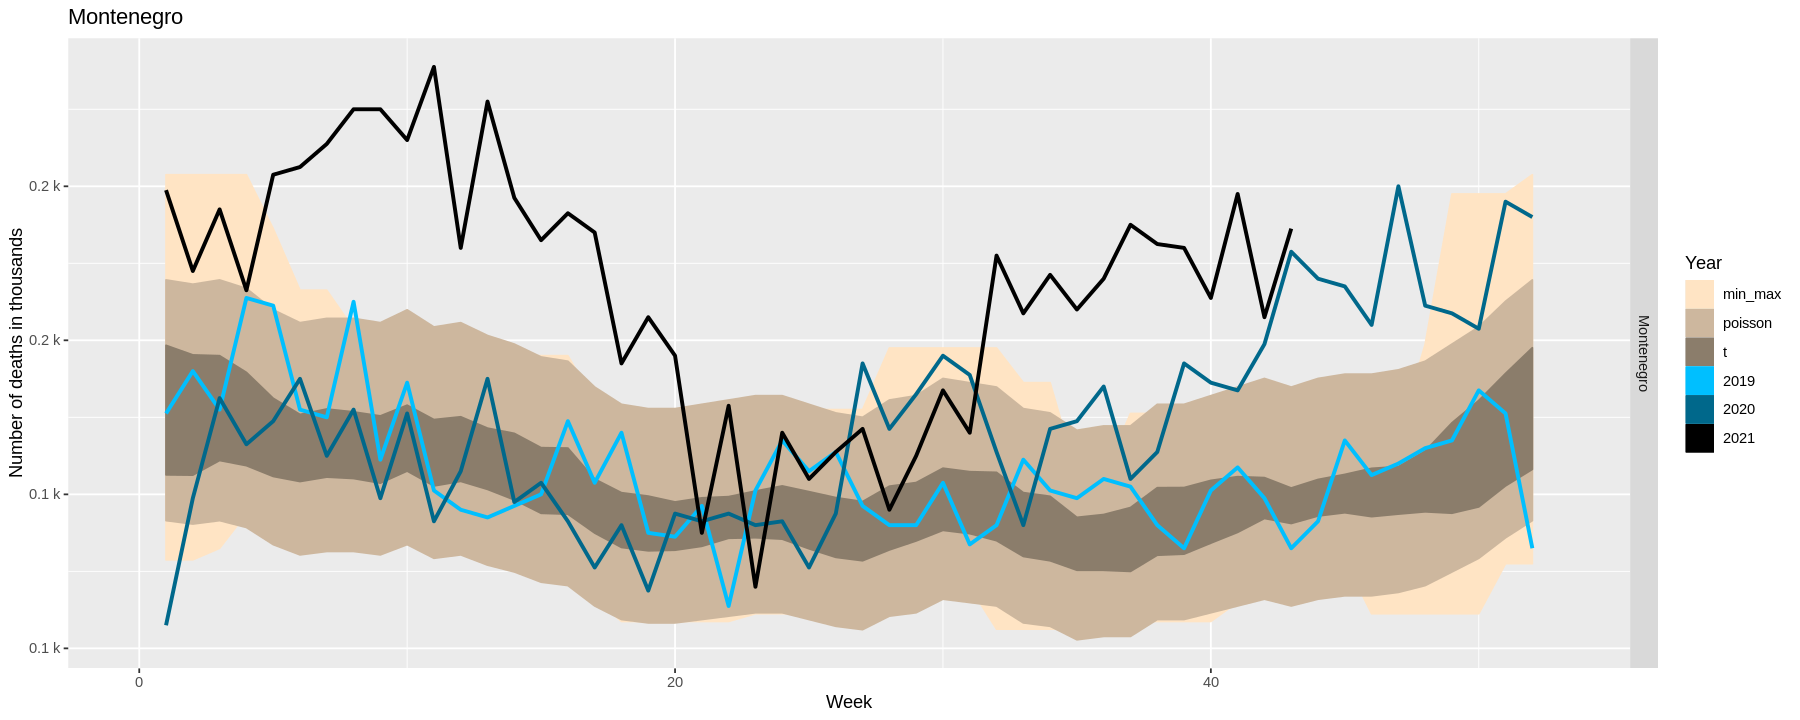

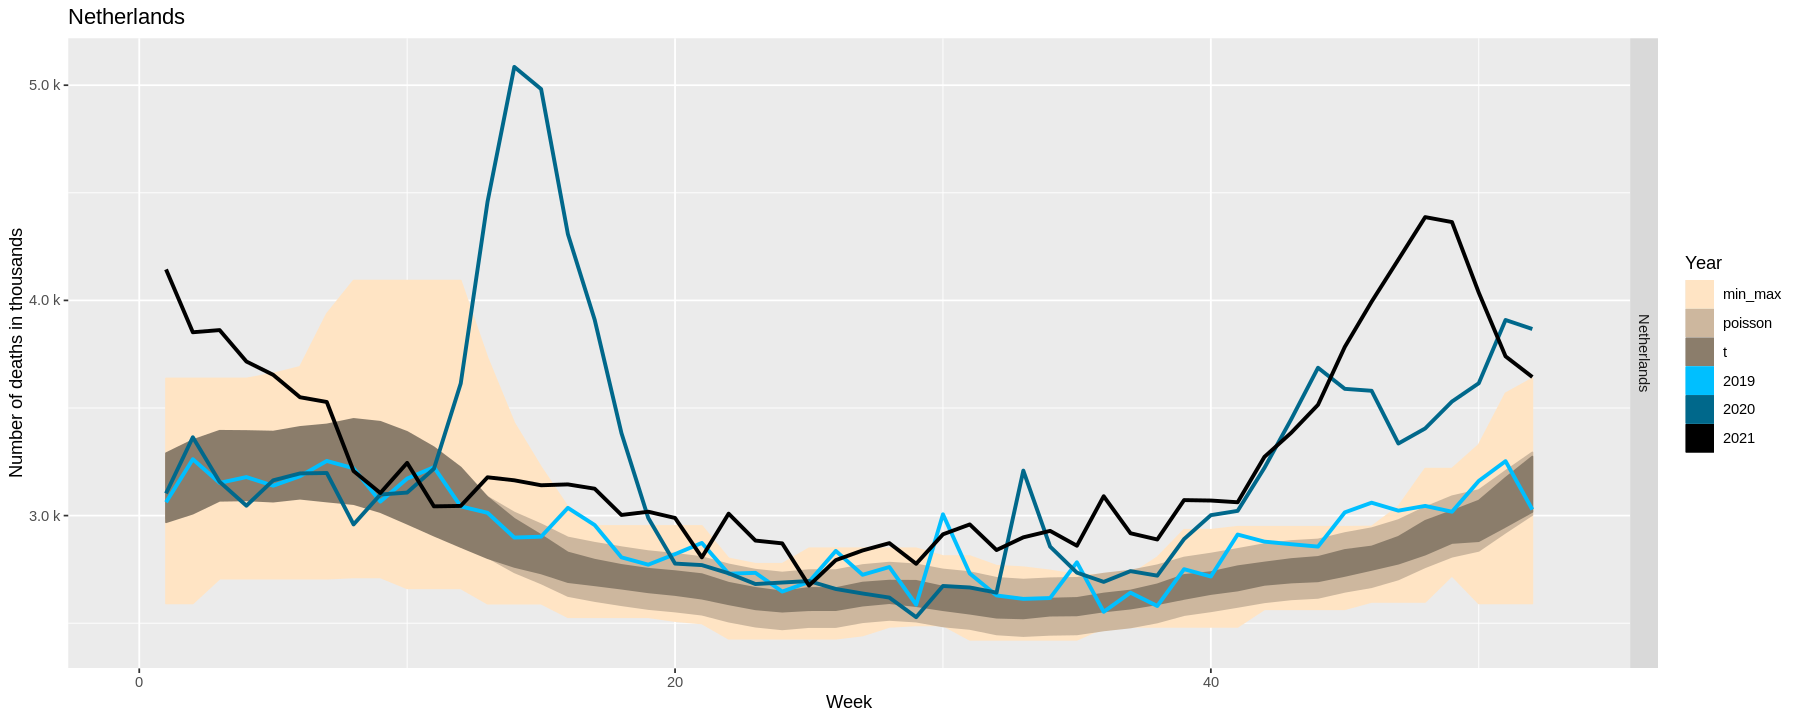

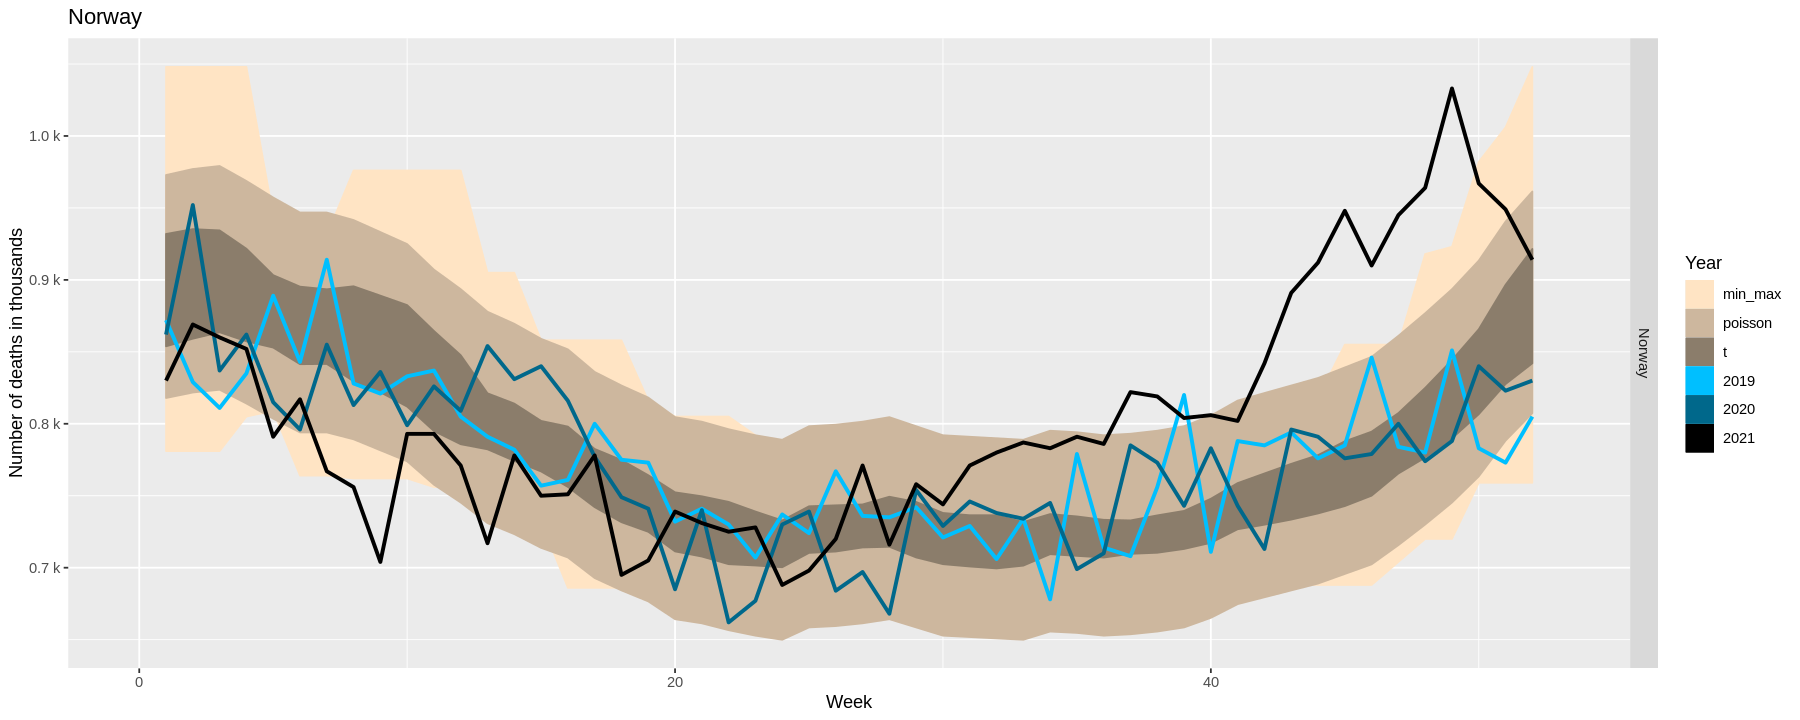

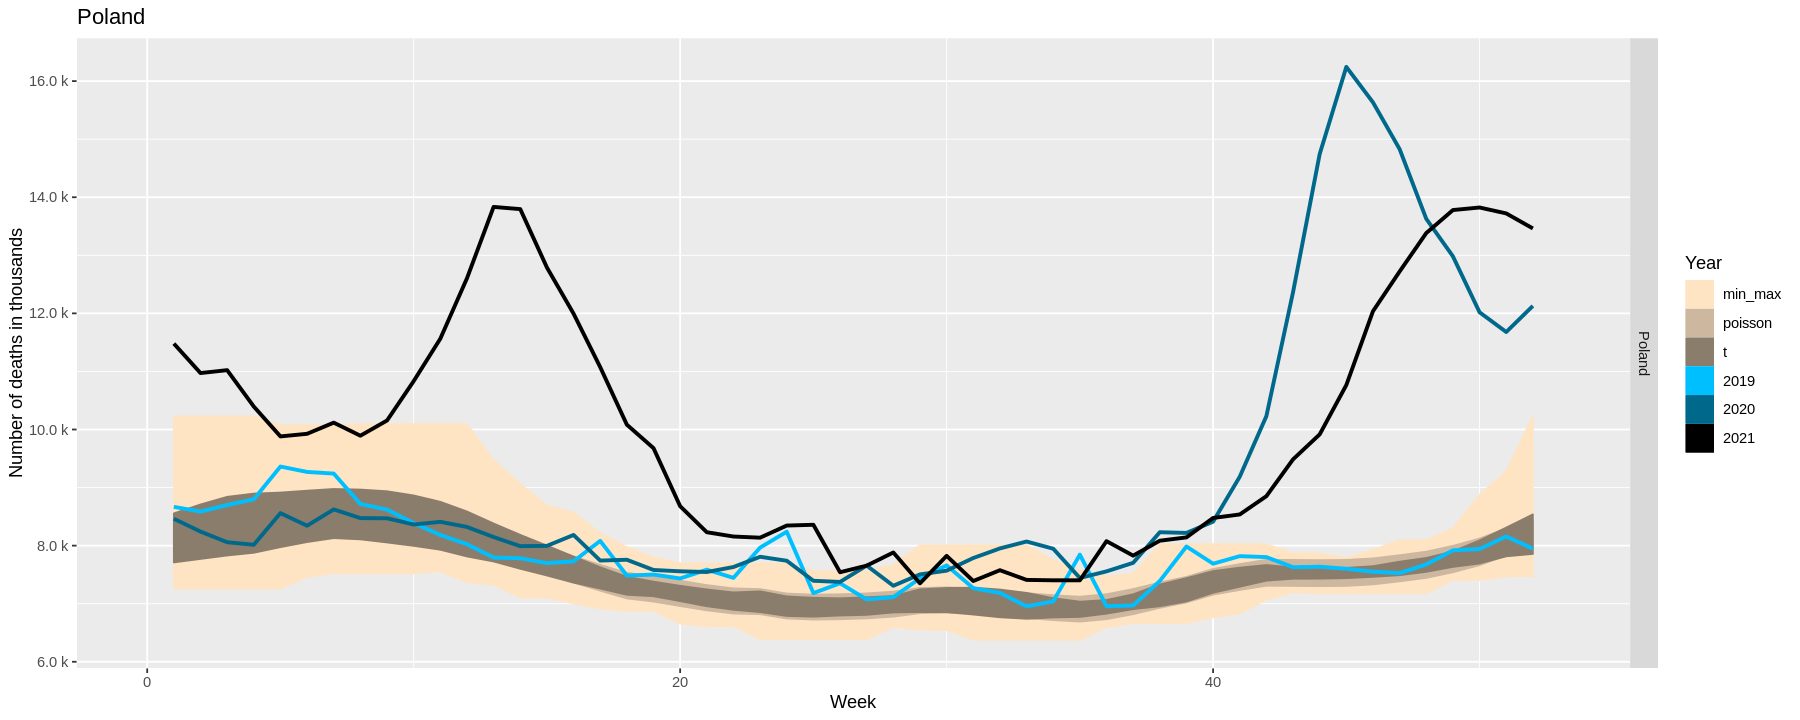

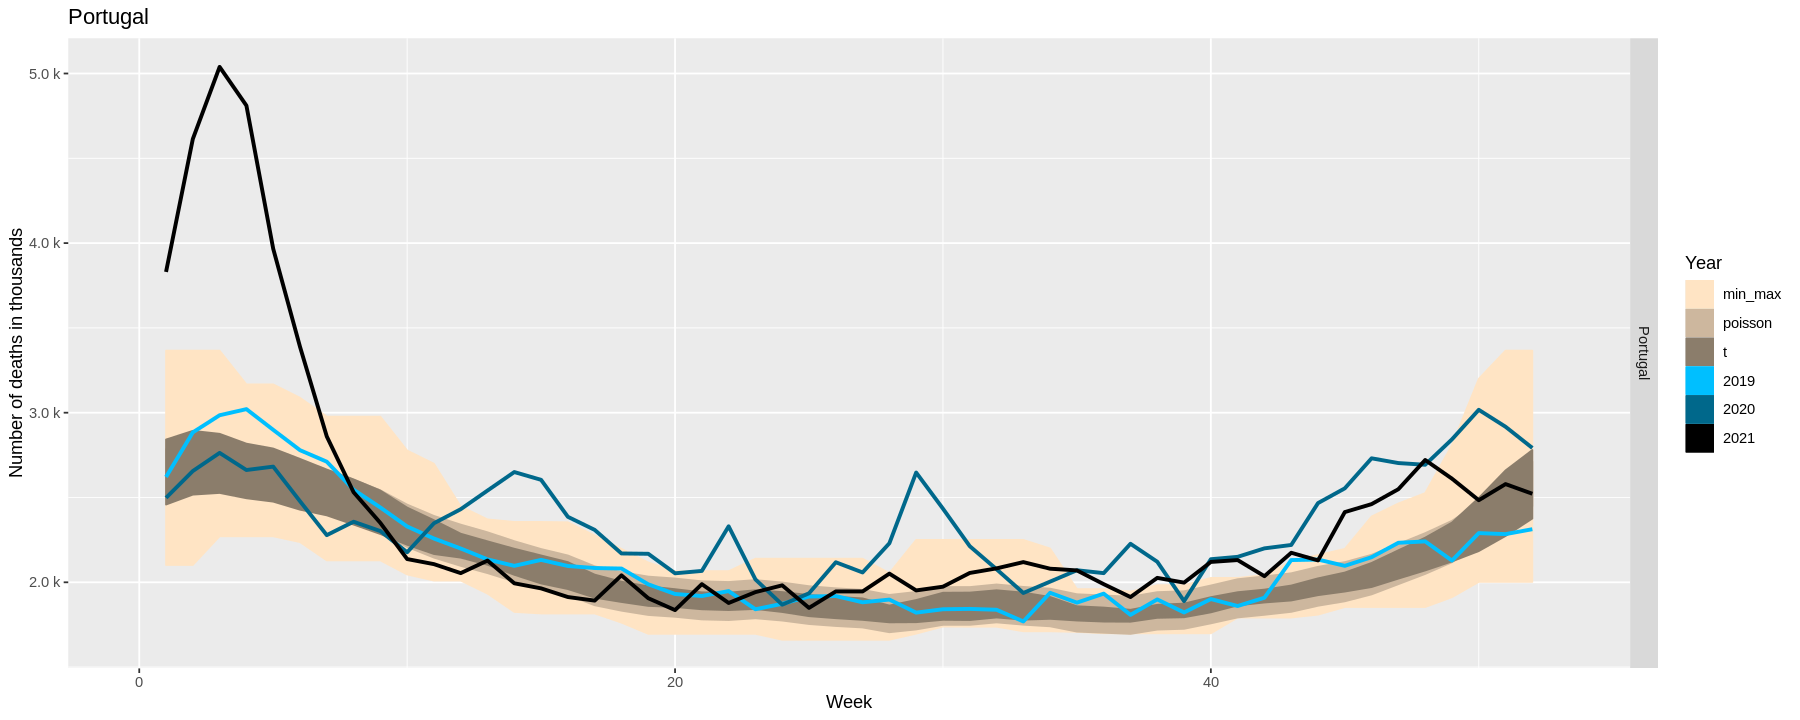

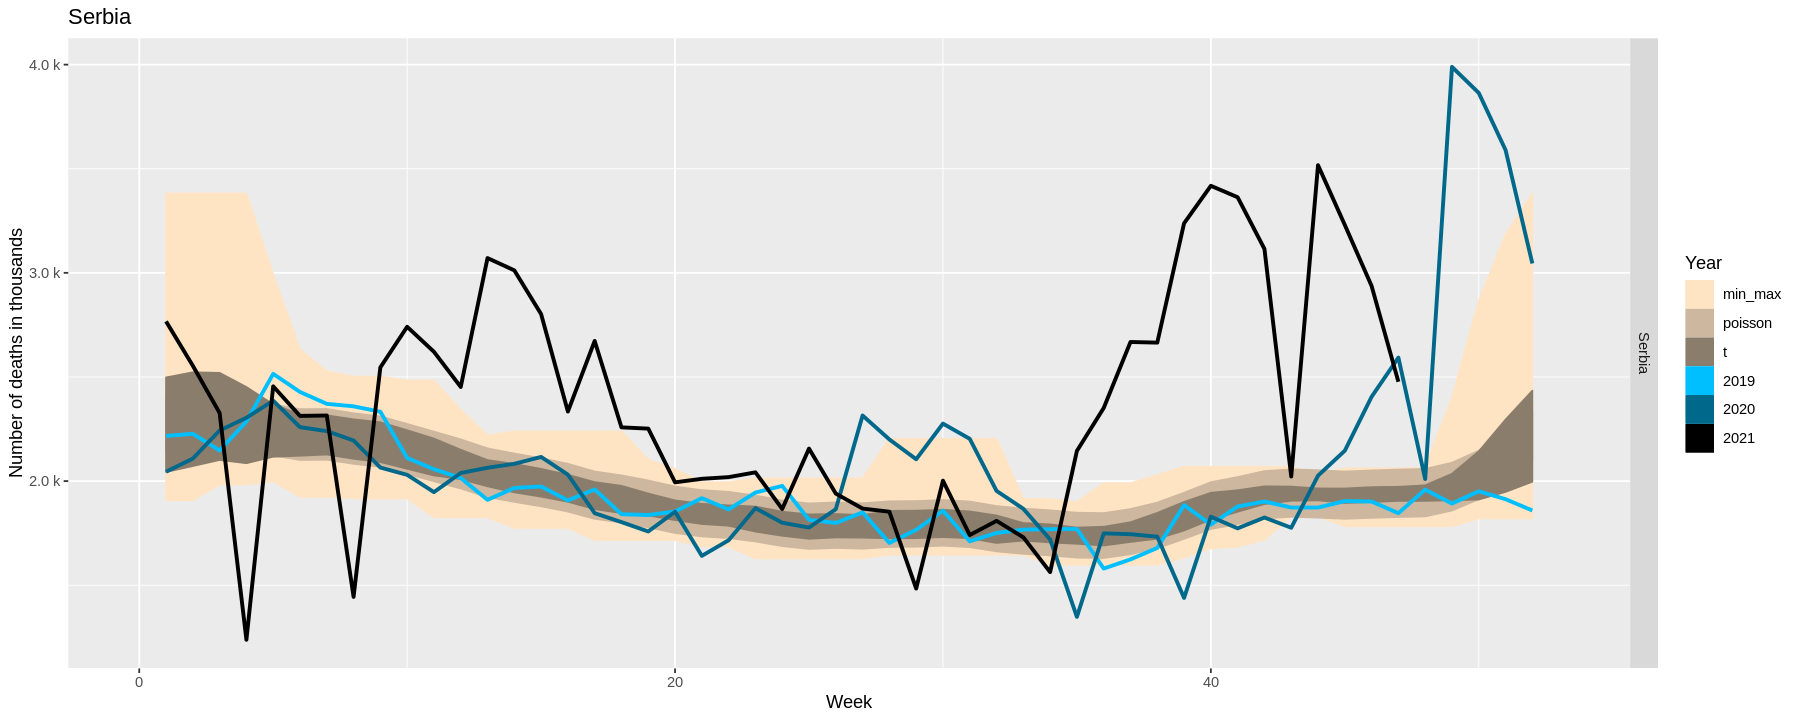

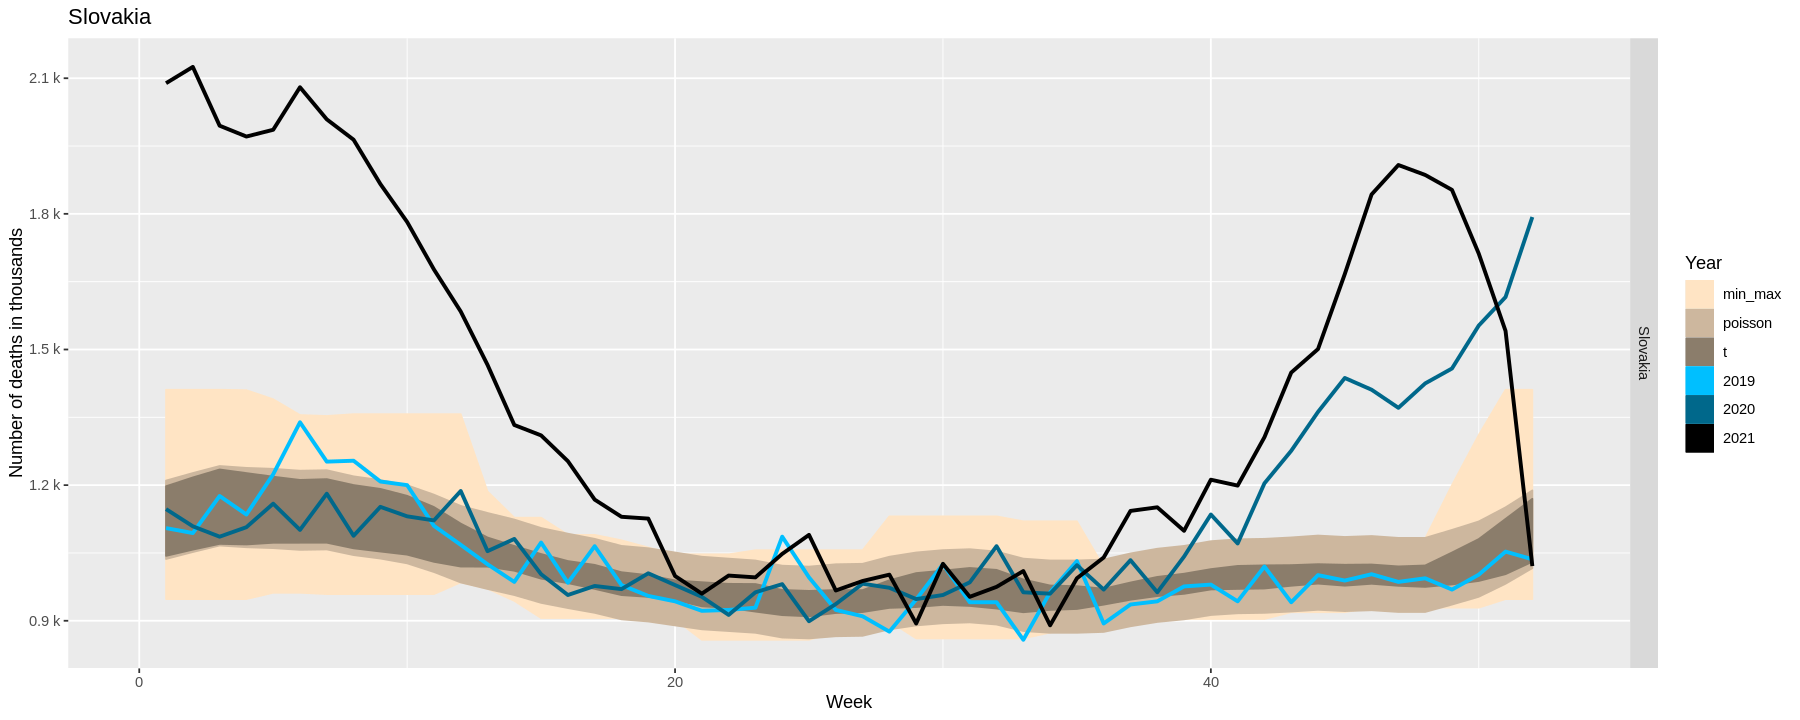

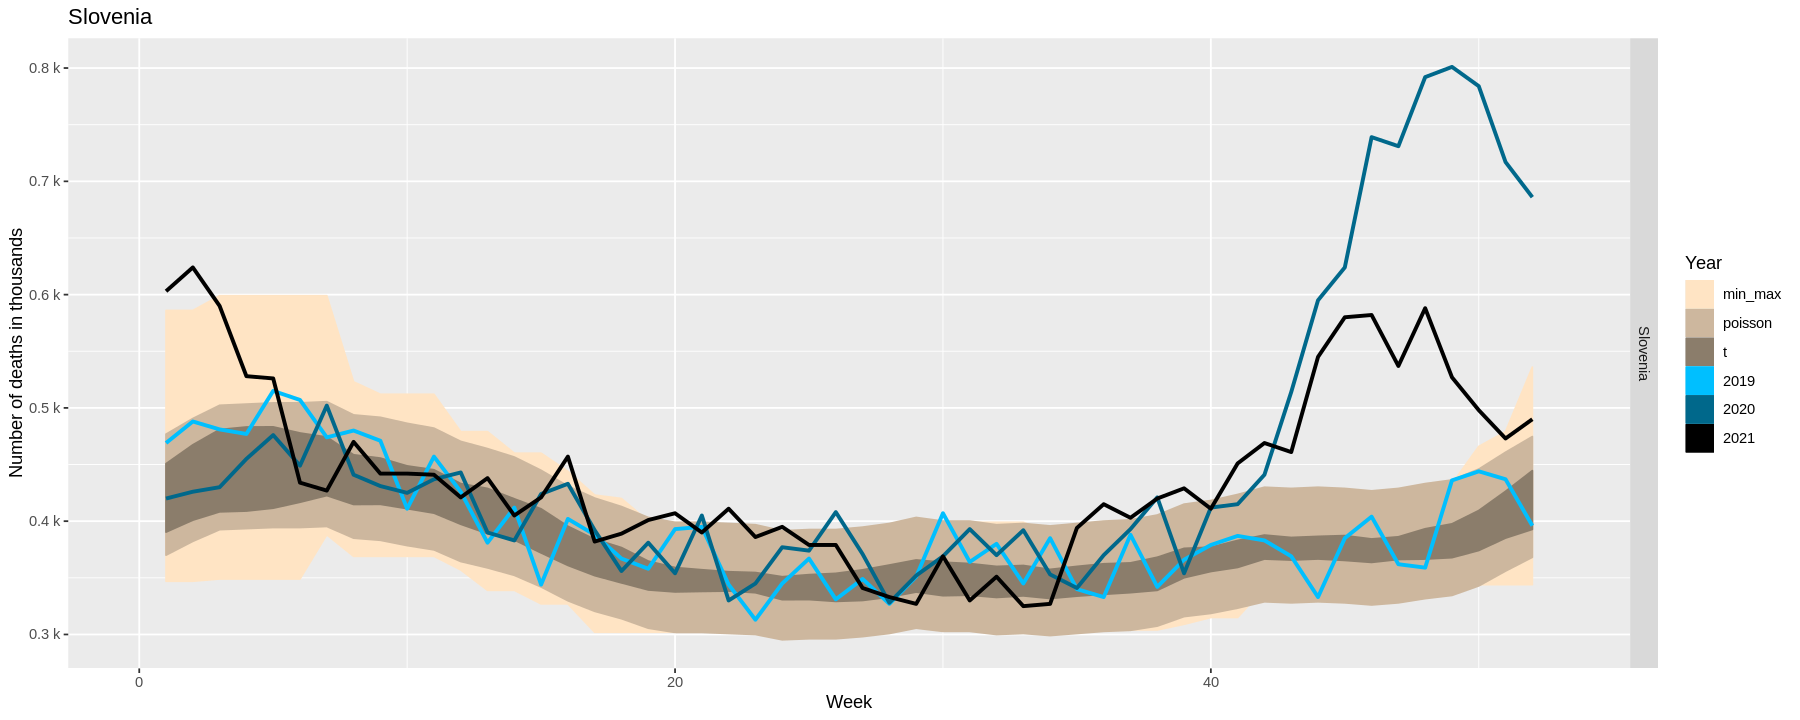

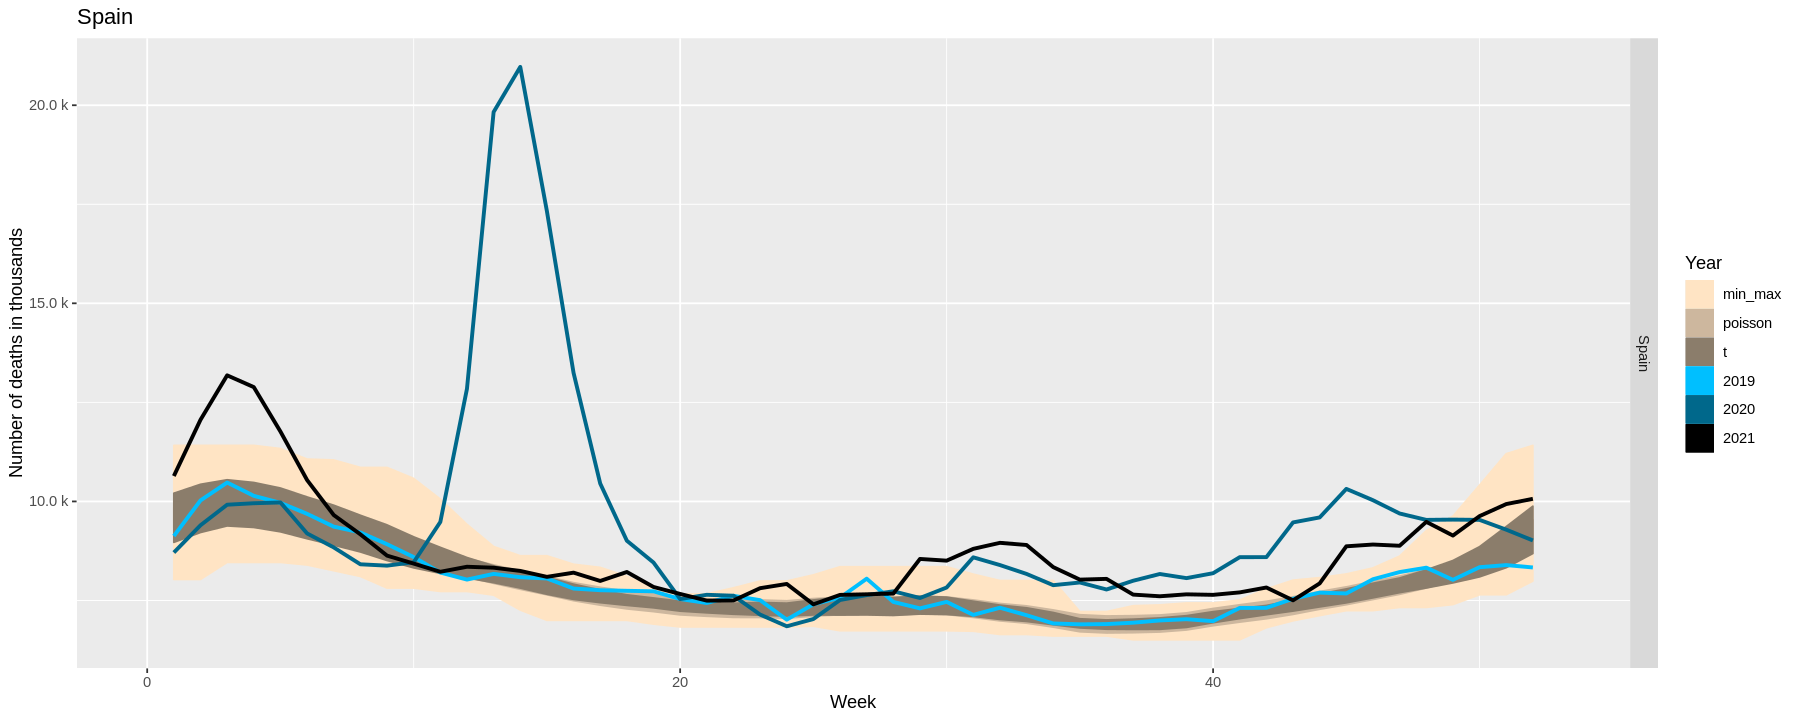

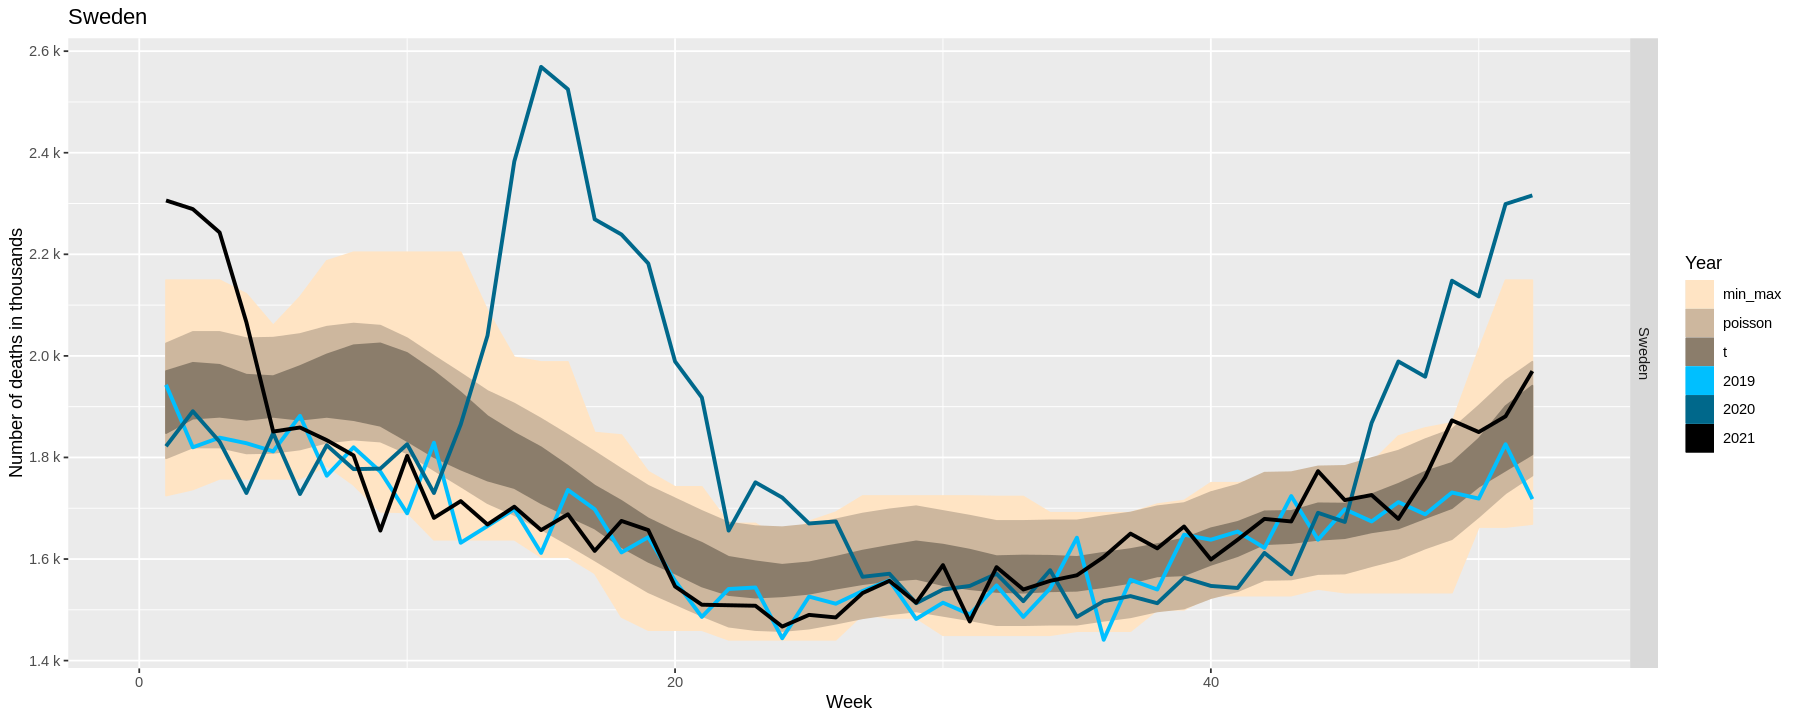

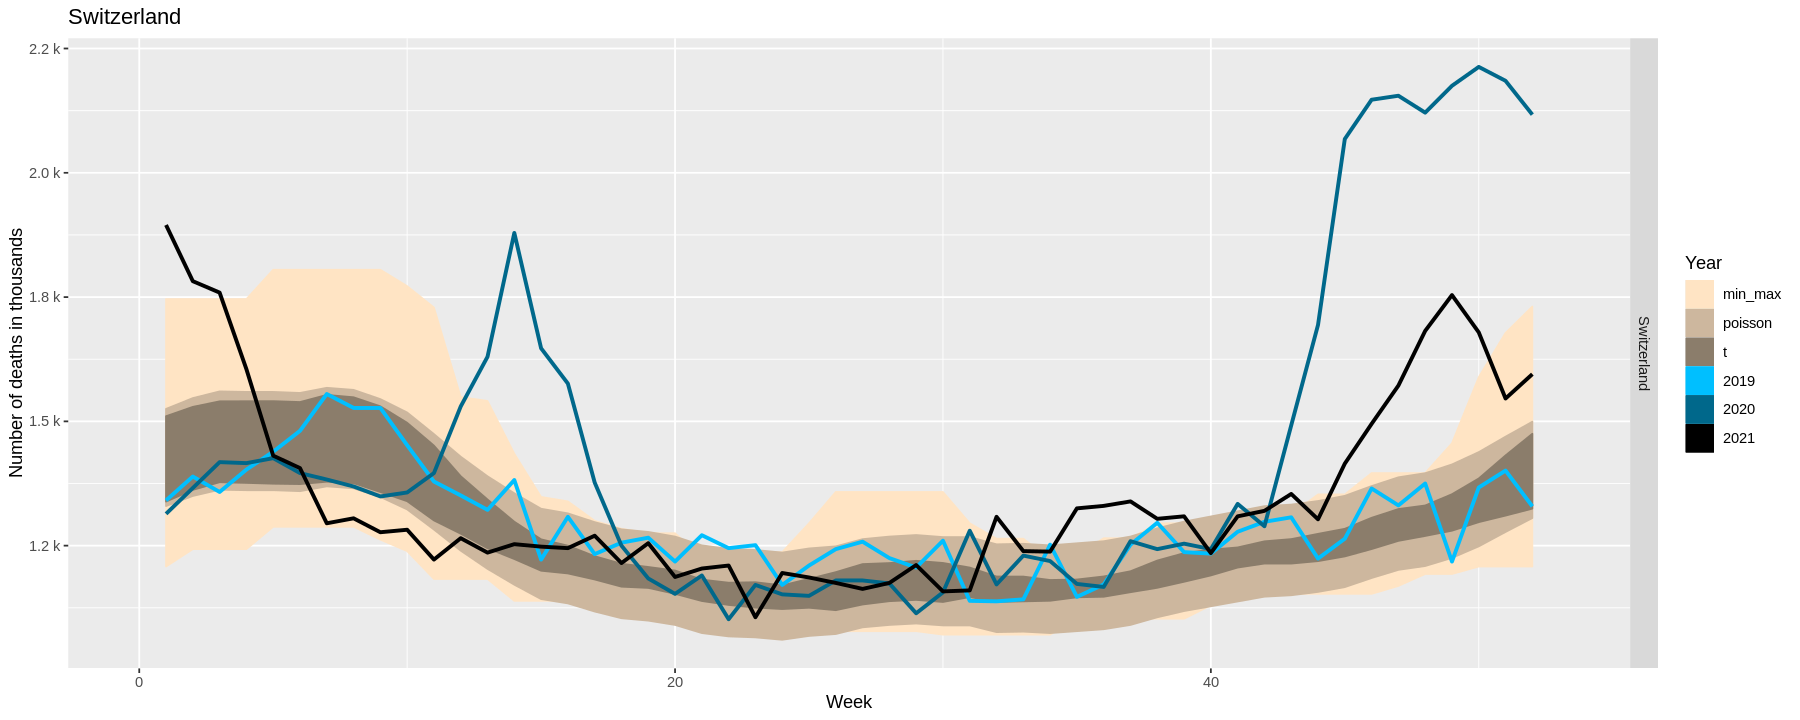

In [12]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(15, 6)
for(i in c(1:length(unique(data$GEO)))){
    print(plot(i))
} 

### Conclusions

- For choosen approach, poisson distribution for values less than 5k deaths looks to give decent coverage of CI for test year 2019
- t distribution is significantly underestimating CI for lower values of deaths approximately below 5k for test year 2019
- For higher value of deaths approximately above 5k poisson and t approaches give very similar CI, and both underestimate slightly CI for test year 2019

- We can notice that all countries with available data suffered peaks in deaths during 2020 and 2021 years
- Most countries faced peaks in deaths during begining or end of winter time